#Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Installs


In [2]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.7 MB/s eta 0:00:00


In [ ]:
!pip install torch torchvision matplotlib seaborn

#Imports

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from google.colab import files
from sklearn.preprocessing import OneHotEncoder
from scipy.optimize import check_grad
from skopt import gp_minimize
from skopt.space import Real, Categorical
from skopt.utils import use_named_args
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, random_split
import seaborn as sns


#Random Seed Initialization

In [4]:
import random

SEED = 1234

np.random.seed(SEED)
random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
uploaded = files.upload()

Saving kmnist_classmap.csv to kmnist_classmap.csv
Saving kmnist-test-imgs.npz to kmnist-test-imgs.npz
Saving kmnist-test-labels.npz to kmnist-test-labels.npz
Saving kmnist-train-imgs.npz to kmnist-train-imgs.npz
Saving kmnist-train-labels.npz to kmnist-train-labels.npz


#Implementing Classes

##MLP


In [6]:


# activations
class Relu:
    @staticmethod
    def activation(z):
        return np.maximum(0, z)

    @staticmethod
    def derivative(z):
        return (z > 0).astype(float)

class Sigmoid:
    @staticmethod
    def activation(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def derivative(z):
        a = Sigmoid.activation(z)
        return a * (1 - a)

class Softmax:
    @staticmethod
    def activation(z):
        z = np.clip(z, -500, 500)
        exp_scores = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

class LeakyRelu:
    alpha = 0.01

    @staticmethod
    def activation(z):
        return np.where(z > 0, z, LeakyRelu.alpha * z)

    @staticmethod
    def derivative(z):
        return np.where(z > 0, 1.0, LeakyRelu.alpha)

# loss function
class CrossEntropy:
    def __init__(self, activation_fn):
        self.activation_fn = activation_fn

    def activation(self, z):
        return self.activation_fn.activation(z)

    @staticmethod
    def loss(y_true, y_pred):
        epsilon = 1e-12
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]

    @staticmethod
    def derivative(y_true, y_pred):
        return y_pred - y_true

# early stopping
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.best_score = -np.inf
        self.counter = 0
        self.stop = False

    def __call__(self, score):
        if score > self.best_score:
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True

# mlp
class MLP:
    def __init__(self, dimensions, activations):
        self.n_layers = len(dimensions)
        self.loss = None
        self.learning_rate = None
        self.lambd = None
        self.weights = []
        self.biases = []
        self.activations = activations

        for i in range(len(dimensions) - 1):
            in_dim, out_dim = dimensions[i], dimensions[i + 1]
            act_fn = activations[i]

            if act_fn == Sigmoid:
                limit = np.sqrt(6 / (in_dim + out_dim))
                w = np.random.uniform(-limit, limit, (in_dim, out_dim))
            elif act_fn in [Relu, LeakyRelu]:
                w = np.random.randn(in_dim, out_dim) * np.sqrt(2. / in_dim)
            else:
                w = np.random.randn(in_dim, out_dim) * 0.01

            self.weights.append(w)
            self.biases.append(np.zeros((1, out_dim)))

    def forward(self, x):
        z_values = []
        a_values = [x]

        for i in range(self.n_layers - 1):
            z = np.dot(a_values[-1], self.weights[i]) + self.biases[i]
            a = self.activations[i].activation(z)
            z_values.append(z)
            a_values.append(a)

        return z_values, a_values

    def update(self, index, dw, delta):
        dw += self.lambd * self.weights[index]
        self.weights[index] -= self.learning_rate * dw
        self.biases[index] -= self.learning_rate * np.mean(delta, axis=0, keepdims=True)

    def backward(self, z_values, a_values, y_true):
        deltas = self.loss.derivative(y_true, a_values[-1])
        grads_w = [None] * (self.n_layers - 1)
        grads_b = [None] * (self.n_layers - 1)

        for i in reversed(range(self.n_layers - 1)):
            grads_w[i] = np.dot(a_values[i].T, deltas)
            grads_b[i] = deltas
            if i > 0:
                deltas = np.dot(deltas, self.weights[i].T) * self.activations[i - 1].derivative(z_values[i - 1])

        for i in range(self.n_layers - 1):
            self.update(i, grads_w[i], grads_b[i])

    def fit(self, X_train, y_train, X_test, y_test, epochs, batch_size, loss_fn, lambd, learning_rate=1e-3, patience=5, verbose=False):

      np.random.seed(1234)

      self.loss = loss_fn(self.activations[-1])
      self.learning_rate = learning_rate
      self.lambd = lambd
      num_classes = len(np.unique(y_train))
      early_stopper = EarlyStopping(patience)

      train_acc_history, test_acc_history, train_loss_history, val_loss_history = [], [], [], []

      for epoch in range(epochs):
          indices = np.random.permutation(X_train.shape[0])
          X_shuff, y_shuff = X_train[indices], y_train[indices]

          for i in range(0, X_train.shape[0], batch_size):
              x_batch = X_shuff[i:i + batch_size]
              y_batch = np.eye(num_classes)[y_shuff[i:i + batch_size]]

              z_vals, a_vals = self.forward(x_batch)
              self.backward(z_vals, a_vals, y_batch)

          train_preds = self.predict(X_train)
          test_preds = self.predict(X_test)
          train_acc = evaluate_acc(y_train, train_preds)
          test_acc = evaluate_acc(y_test, test_preds)
          train_acc_history.append(train_acc)
          test_acc_history.append(test_acc)

          _, a_train = self.forward(X_train)
          y_train_onehot = np.eye(num_classes)[y_train]
          train_loss = self.loss.loss(y_train_onehot, a_train[-1])
          train_loss_history.append(train_loss)

          _, a_val = self.forward(X_test)
          y_val_onehot = np.eye(num_classes)[y_test]
          val_loss = self.loss.loss(y_val_onehot, a_val[-1])
          val_loss_history.append(val_loss)

          if verbose:
              print(f"Epoch {epoch + 1} - Train Acc: {train_acc:.4f} - Test Acc: {test_acc:.4f} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

          early_stopper(test_acc)
          if early_stopper.stop:
              if verbose:
                  print(f"Early stopping at epoch {epoch + 1}")
              break

      return train_acc_history, test_acc_history, train_loss_history, val_loss_history


    def predict(self, x):
        _, activations = self.forward(x)
        return np.argmax(activations[-1], axis=1)

    def set_weights(self, flattened_params, weight_shapes, bias_shapes):
        idx = 0
        for i, shape in enumerate(weight_shapes):
            size = np.prod(shape)
            self.weights[i] = flattened_params[idx:idx + size].reshape(shape)
            idx += size
        for i, shape in enumerate(bias_shapes):
            size = np.prod(shape)
            self.biases[i] = flattened_params[idx:idx + size].reshape(shape)
            idx += size

    def gradient_check(self, X, y_true, num_classes, epsilon=1e-7):
        weight_shapes = [w.shape for w in self.weights]
        bias_shapes = [b.shape for b in self.biases]
        params_vector = np.concatenate([w.flatten() for w in self.weights] + [b.flatten() for b in self.biases])
        y_onehot = np.eye(num_classes)[y_true]

        def loss_func(params):
            self.set_weights(params, weight_shapes, bias_shapes)
            _, a = self.forward(X)
            loss_val = self.loss.loss(y_onehot, a[-1])
            reg = 0.5 * self.lambd * sum(np.sum(w ** 2) for w in self.weights)
            return loss_val + reg

        def grad_func(params):
            self.set_weights(params, weight_shapes, bias_shapes)
            z, a = self.forward(X)
            delta = (a[-1] - y_onehot) / X.shape[0]

            dw = []
            db = []

            for i in reversed(range(self.n_layers - 1)):
                w_grad = np.dot(a[i].T, delta) + self.lambd * self.weights[i]
                b_grad = np.sum(delta, axis=0)
                dw.insert(0, w_grad)
                db.insert(0, b_grad)
                if i > 0:
                    delta = np.dot(delta, self.weights[i].T) * self.activations[i - 1].derivative(z[i - 1])

            grad_vector = np.concatenate([g.flatten() for g in dw + db])
            return grad_vector

        num_grad = self._numerical_gradient(loss_func, params_vector, epsilon)
        backprop_grad = grad_func(params_vector)

        rel_diff = np.linalg.norm(num_grad - backprop_grad) / (np.linalg.norm(num_grad + backprop_grad) + 1e-12)
        print(f"[DEBUG] Gradient Check - Relative Difference: {rel_diff:.8f}")
        if rel_diff < 1e-4:
            print("Gradients are correct!")
        else:
            print("Gradient incorrect!")
        return rel_diff

    def _numerical_gradient(self, func, params, epsilon):
        grad = np.zeros_like(params)
        for i in range(len(params)):
            params[i] += epsilon
            plus = func(params)
            params[i] -= 2 * epsilon
            minus = func(params)
            grad[i] = (plus - minus) / (2 * epsilon)
            params[i] += epsilon
        return grad


def evaluate_acc(true_labels, predicted_labels):
    return np.mean(true_labels == predicted_labels)


##CNN

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ConvNet(nn.Module):
    def __init__(self, fc_hidden_units=128):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, fc_hidden_units)
        self.fc2 = nn.Linear(fc_hidden_units, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

##CNN for Hyperparameter tuning

In [8]:
import torch
import torch.nn as nn


class CustomConvNet(nn.Module):
    def __init__(self, num_filters=32, kernel_size=3, stride=1, padding=1, dropout=0.5, fc_hidden=128):
        super().__init__()

        self.conv1 = nn.Conv2d(1, num_filters, kernel_size, stride, padding)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(num_filters, num_filters * 2, kernel_size, stride, padding)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(num_filters * 2, num_filters * 4, kernel_size, stride, padding)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)


        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 28, 28)
            out = self.pool1(self.relu1(self.conv1(dummy_input)))
            out = self.pool2(self.relu2(self.conv2(out)))
            out = self.pool3(self.relu3(self.conv3(out)))
            self.flatten_dim = out.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flatten_dim, fc_hidden)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(fc_hidden, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.fc1(x))
        return self.fc2(x)


In [16]:
class CNNTrainer:
    def __init__(self, model, device, lr=1e-3, patience=5):
        self.model = model.to(device)
        self.device = device
        self.lr = lr
        self.patience = patience
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss()

    def train(self, train_loader, val_loader=None, test_loader=None, epochs=20):
        best_val_acc = 0
        early_stop_counter = 0
        use_early_stopping = val_loader is not None
        best_model_state = self.model.state_dict()

        history = {
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": [],
            "test_acc": []
        }

        for epoch in range(epochs):
            self.model.train()
            total_loss, correct, total = 0.0, 0, 0

            for xb, yb in train_loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(xb)
                loss = self.criterion(outputs, yb)
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item() * xb.size(0)
                correct += (outputs.argmax(dim=1) == yb).sum().item()
                total += yb.size(0)

            train_loss = total_loss / total
            train_acc = correct / total

            history["train_loss"].append(train_loss)
            history["train_acc"].append(train_acc)

            # Validation
            if val_loader is not None:
                val_loss, val_acc = self.evaluate(val_loader)
                history["val_loss"].append(val_loss)
                history["val_acc"].append(val_acc)
            else:
                val_loss, val_acc = None, None


            if test_loader is not None:
                _, test_acc = self.evaluate(test_loader)
                history["test_acc"].append(test_acc)
            else:
                test_acc = None


            log_msg = f"Epoch {epoch + 1:02d} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}"
            if val_loader is not None:
                log_msg += f" | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}"
            if test_loader is not None:
                log_msg += f" | Test Acc: {test_acc:.4f}"
            print(log_msg)


            if val_loader is not None:
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    early_stop_counter = 0
                    best_model_state = self.model.state_dict()
                else:
                    early_stop_counter += 1
                    if early_stop_counter >= self.patience:
                        print(f"Early stopping at epoch {epoch + 1}")
                        break

        if use_early_stopping:
            self.model.load_state_dict(best_model_state)

        return history

    def evaluate(self, data_loader):
        if data_loader is None:
            raise ValueError("Data loader is None — evaluation requires a valid data loader.")

        self.model.eval()
        total_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for xb, yb in data_loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                outputs = self.model(xb)
                loss = self.criterion(outputs, yb)

                total_loss += loss.item() * xb.size(0)
                correct += (outputs.argmax(dim=1) == yb).sum().item()
                total += yb.size(0)

        return total_loss / total, correct / total

    def test_accuracy(self, test_loader):
        _, acc = self.evaluate(test_loader)
        print(f"Test Accuracy: {acc:.4f}")
        return acc


#Helper Functions


##Data Handling


In [9]:
def load_kmnist(flatten=True, standardize=True, subset_size=10000):
    X_train = np.load("kmnist-train-imgs.npz")["arr_0"]
    y_train = np.load("kmnist-train-labels.npz")["arr_0"]
    X_test = np.load("kmnist-test-imgs.npz")["arr_0"]
    y_test = np.load("kmnist-test-labels.npz")["arr_0"]

    if flatten:
        X_train = X_train.reshape(len(X_train), -1)
        X_test = X_test.reshape(len(X_test), -1)

    if standardize:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    if subset_size < len(X_train):
        indices = np.random.choice(len(X_train), subset_size, replace=False)
        X_train, y_train = X_train[indices], y_train[indices]

    return X_train, y_train, X_test, y_test

##Grid Search

In [10]:
def run_grid_search(
    X_train, y_train, X_val, y_val, hidden_configs, activation_fn,
    learning_rates, lambdas, batch_sizes, title="MLP"
):
    results = []
    for lr in learning_rates:
        for lambd in lambdas:
            for batch_size in batch_sizes:
                for config in hidden_configs:
                    dims = [X_train.shape[1]] + config + [len(np.unique(y_train))]
                    activs = [activation_fn] * len(config) + [Softmax]
                    model = MLP(dims, activs)


                    train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist = model.fit(
                        X_train, y_train,
                        X_val, y_val,
                        epochs=20, batch_size=batch_size,
                        loss_fn=CrossEntropy, lambd=lambd, learning_rate=lr
                    )

                    val_preds = model.predict(X_val)
                    val_accuracy = evaluate_acc(y_val, val_preds)
                    results.append({
                        "learning_rate": lr,
                        "lambd": lambd,
                        "batch_size": batch_size,
                        "hidden_units": config,
                        "val_accuracy": val_accuracy
                    })

                    print(f"{title} | Config: {config}, Val Accuracy: {val_accuracy:.4f}")


                    plt.figure(figsize=(12, 4))


                    plt.subplot(1, 2, 1)
                    plt.plot(train_acc_hist, label="Train Accuracy")
                    plt.plot(val_acc_hist, label="Validation Accuracy")
                    plt.xlabel("Epoch")
                    plt.ylabel("Accuracy")
                    plt.title(f"{title} Accuracy\nlr={lr}, λ={lambd}, batch={batch_size}, hidden={config}")
                    plt.legend()
                    plt.grid(True)

                    # Loss
                    plt.subplot(1, 2, 2)
                    plt.plot(train_loss_hist, label="Train Loss")
                    plt.plot(val_loss_hist, label="Validation Loss")
                    plt.xlabel("Epoch")
                    plt.ylabel("Loss")
                    plt.title(f"{title} Loss\nlr={lr}, λ={lambd}, batch={batch_size}, hidden={config}")
                    plt.legend()
                    plt.grid(True)

                    plt.tight_layout()
                    plt.show()

    return sorted(results, key=lambda x: x['val_accuracy'], reverse=True)


##accuracy curve for mlp

In [11]:
def plot_accuracy_curves(train_acc_hist, test_acc_hist, model_name="Model"):
    epochs = range(1, len(train_acc_hist) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_acc_hist, label="Train Accuracy")
    plt.plot(epochs, test_acc_hist, label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} Accuracy Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


##Plotting Loss

In [12]:


def plot_loss_curve(train_loss_history, model_name="Model"):
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss_history, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


##history for cnn

In [13]:
def plot_history(history, title="Training History"):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    if "val_loss" in history and history["val_loss"]:
        plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    # sccuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    if "val_acc" in history and history["val_acc"]:
        plt.plot(epochs, history["val_acc"], label="Val Accuracy")
    if "test_acc" in history and history["test_acc"]:
        plt.plot(epochs, history["test_acc"], label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


#MLP (ALL MODELS)

##Loop over all configurations


=== Running experiments for: No Hidden ===
No Hidden | Config: [], Val Accuracy: 0.7825


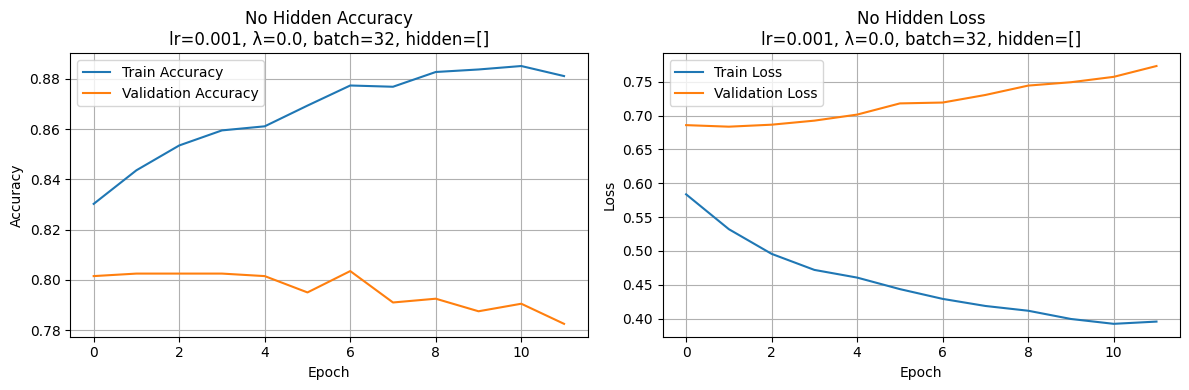

No Hidden | Config: [], Val Accuracy: 0.7950


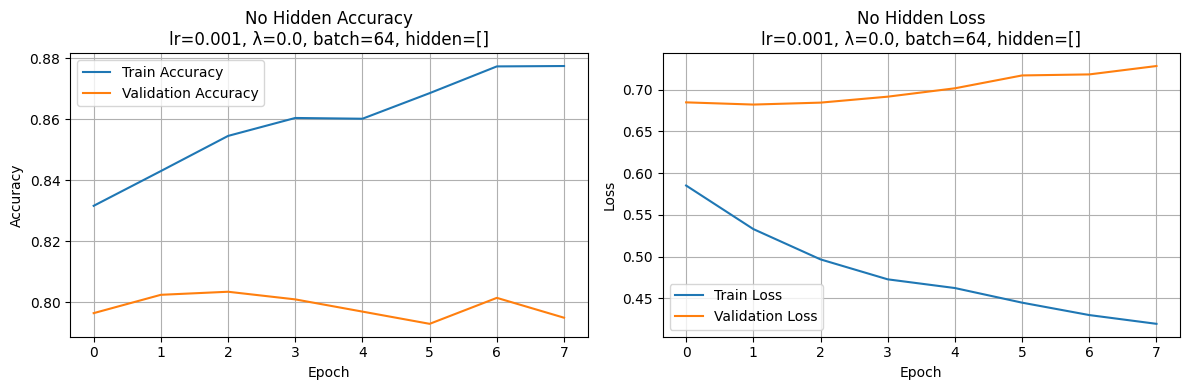

No Hidden | Config: [], Val Accuracy: 0.7785


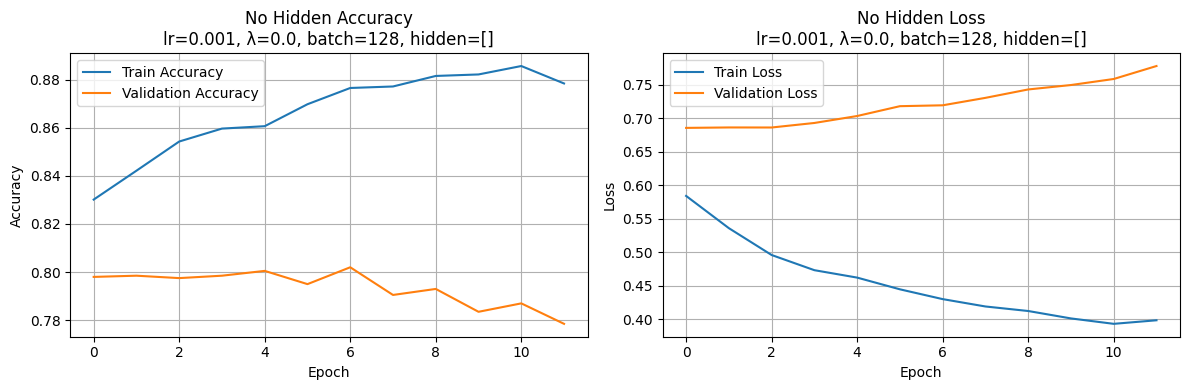

No Hidden | Config: [], Val Accuracy: 0.7925


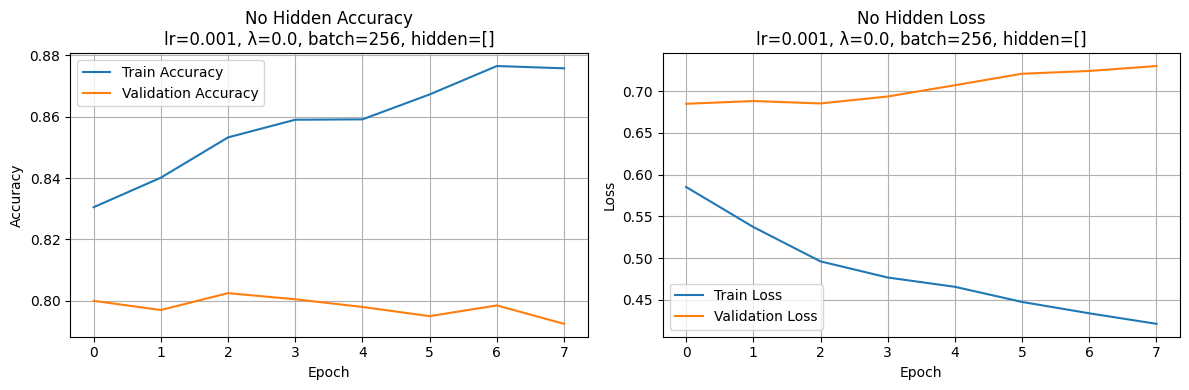

No Hidden | Config: [], Val Accuracy: 0.8015


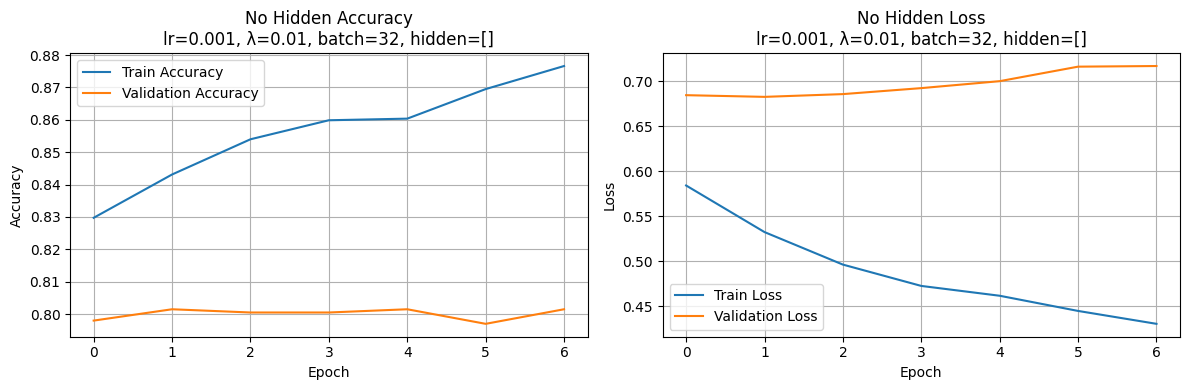

No Hidden | Config: [], Val Accuracy: 0.7995


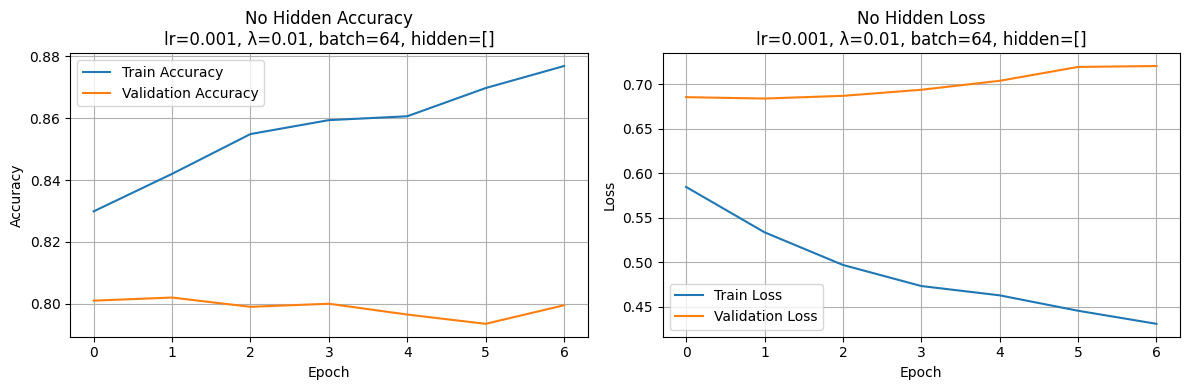

No Hidden | Config: [], Val Accuracy: 0.7815


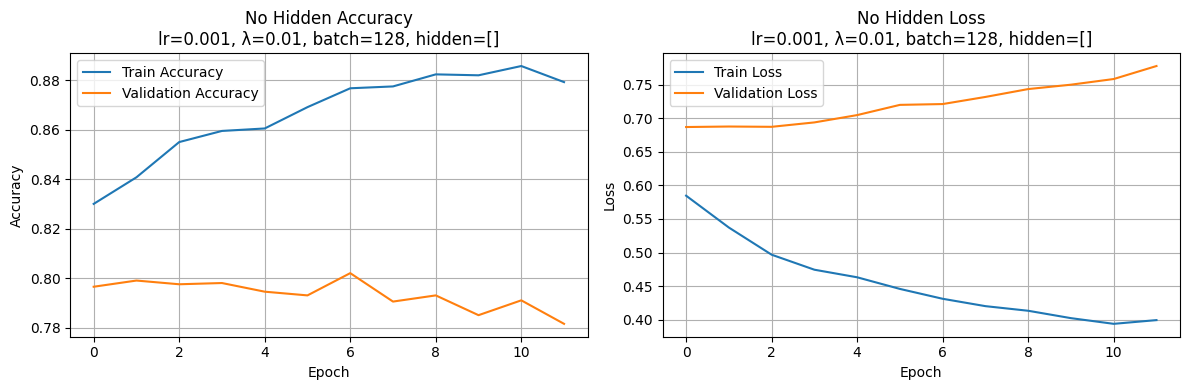

No Hidden | Config: [], Val Accuracy: 0.7930


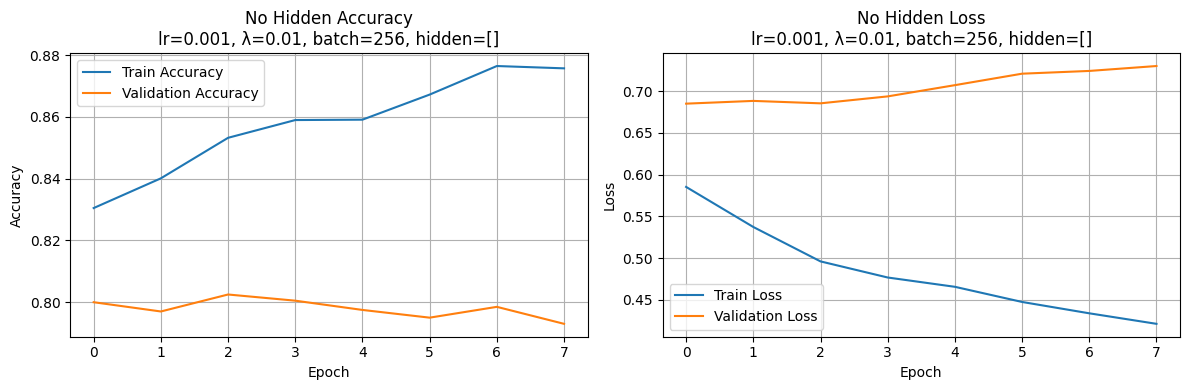

No Hidden | Config: [], Val Accuracy: 0.8070


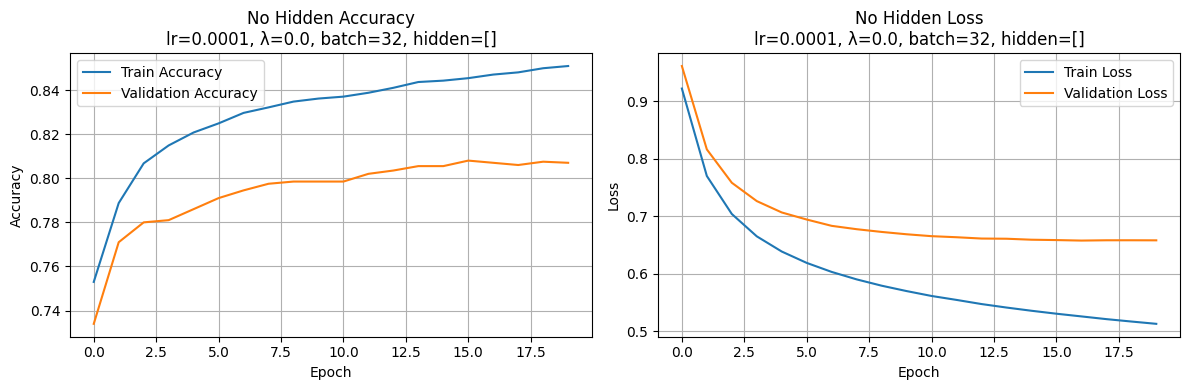

No Hidden | Config: [], Val Accuracy: 0.8080


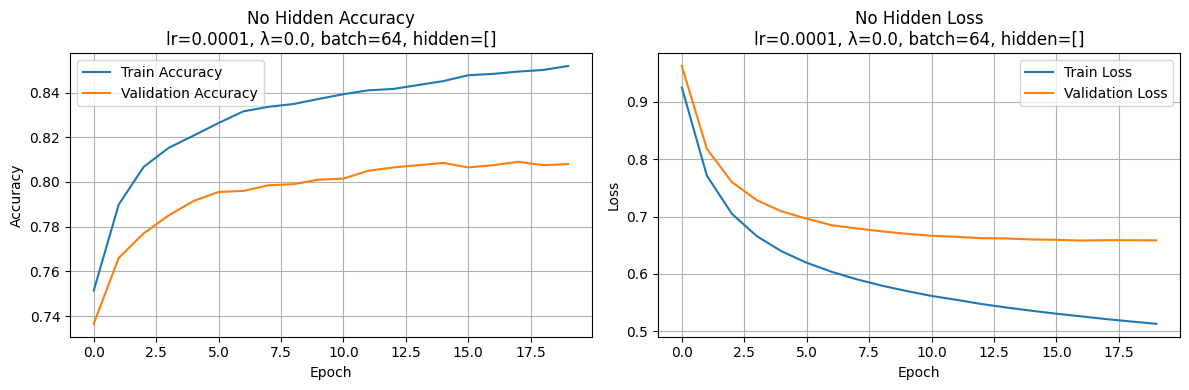

No Hidden | Config: [], Val Accuracy: 0.8075


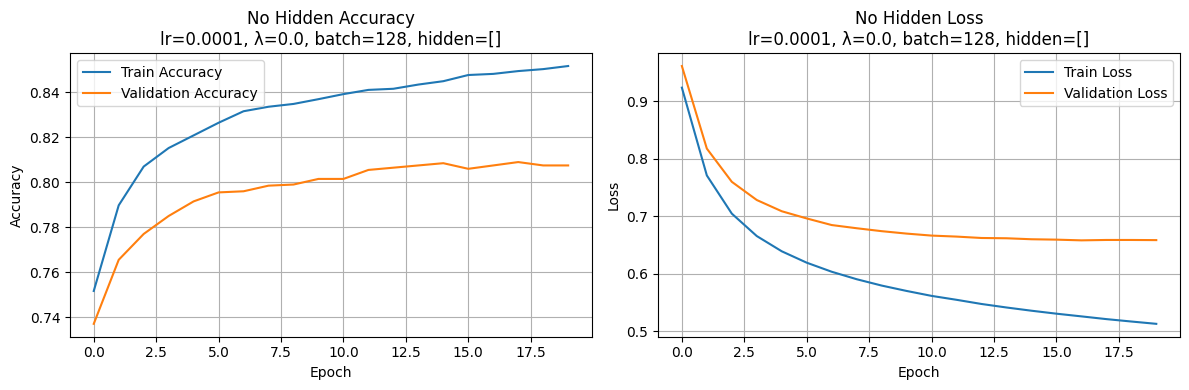

No Hidden | Config: [], Val Accuracy: 0.8075


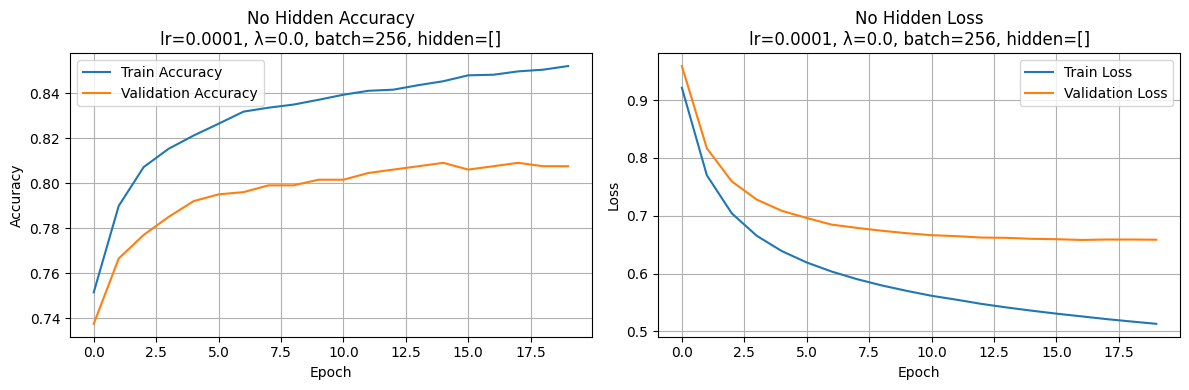

No Hidden | Config: [], Val Accuracy: 0.8075


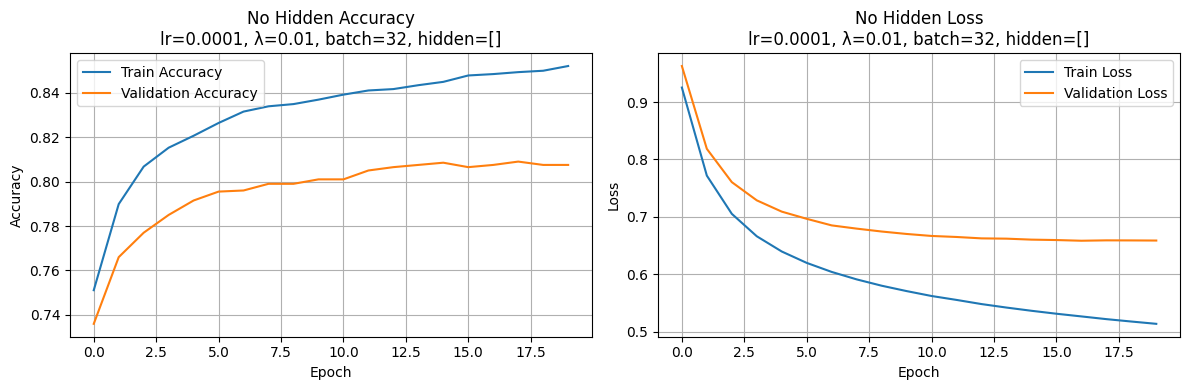

No Hidden | Config: [], Val Accuracy: 0.8075


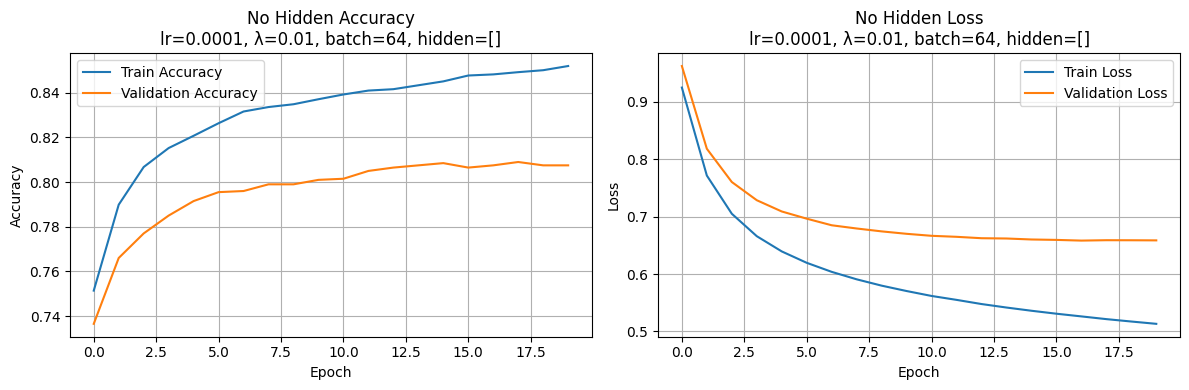

No Hidden | Config: [], Val Accuracy: 0.8075


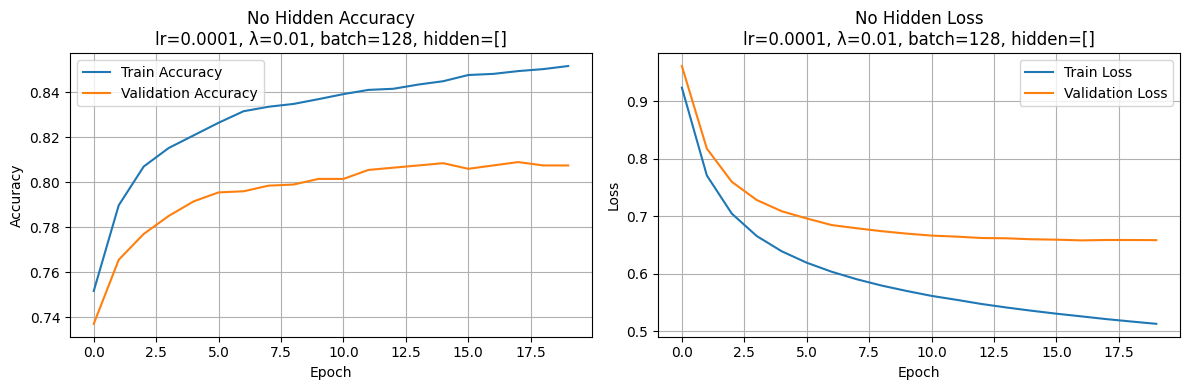

No Hidden | Config: [], Val Accuracy: 0.8075


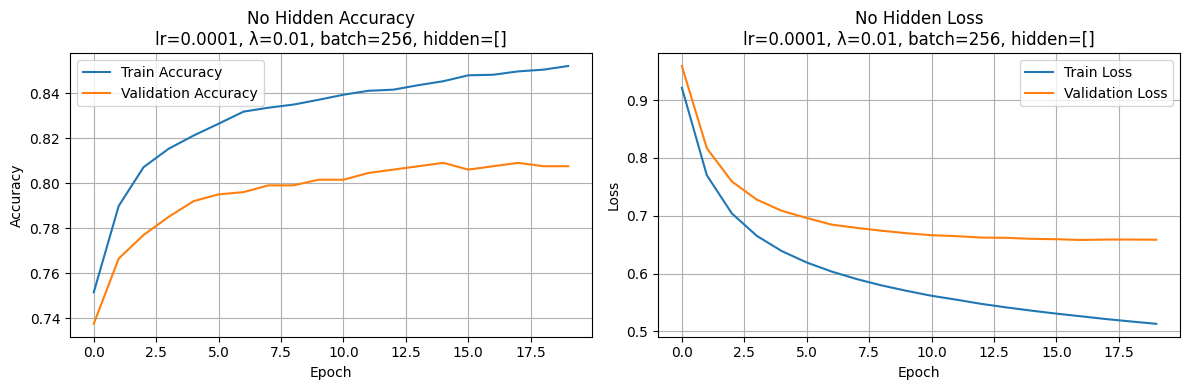


Best Result for No Hidden:
 - Hidden Units: []
 - Learning Rate: 0.0001
 - Lambda: 0.0
 - Batch Size: 64
 - Validation Accuracy: 0.8080

=== Running experiments for: 1 Hidden (ReLU) ===
1 Hidden (ReLU) | Config: [32], Val Accuracy: 0.8695


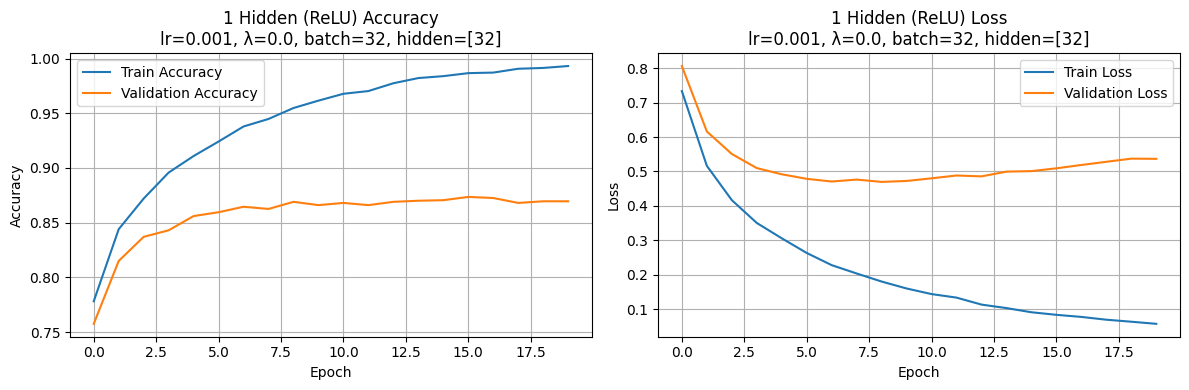

1 Hidden (ReLU) | Config: [64], Val Accuracy: 0.8830


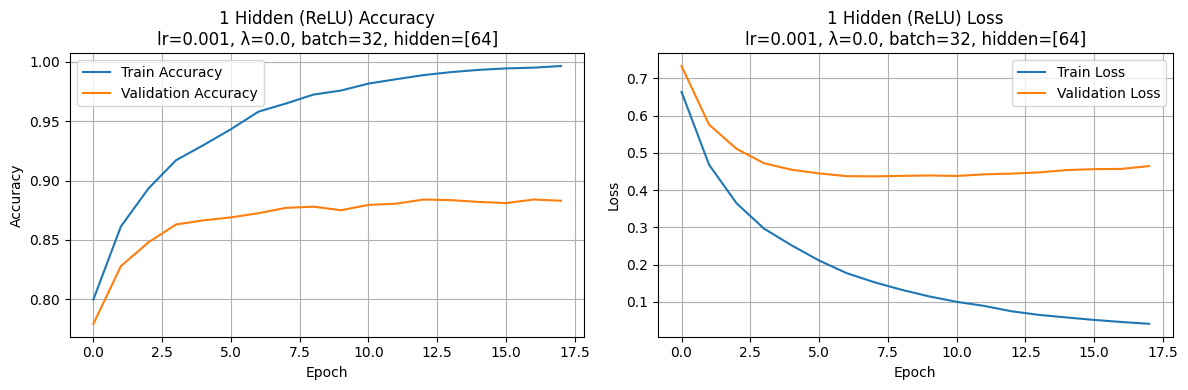

1 Hidden (ReLU) | Config: [128], Val Accuracy: 0.8935


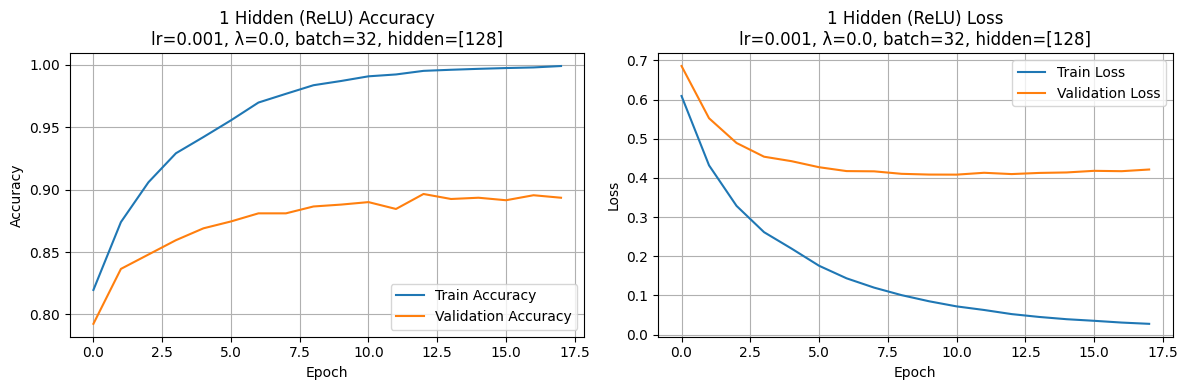

1 Hidden (ReLU) | Config: [256], Val Accuracy: 0.8845


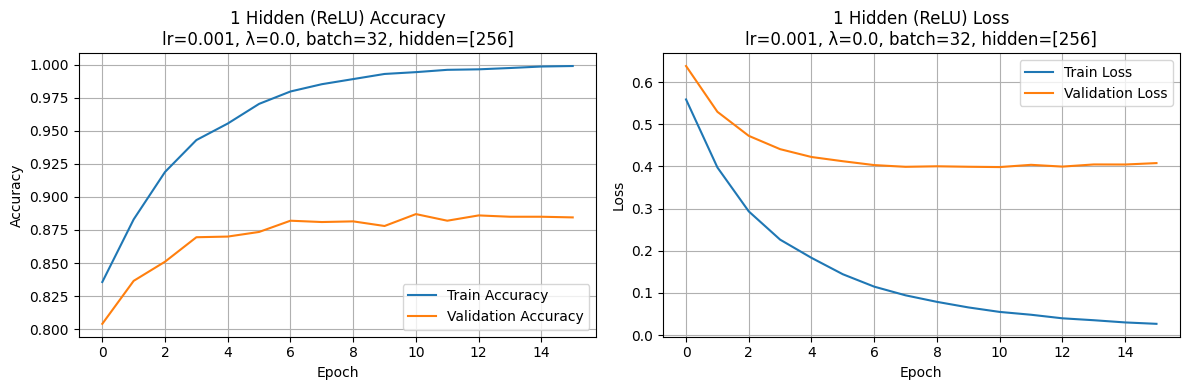

1 Hidden (ReLU) | Config: [32], Val Accuracy: 0.8670


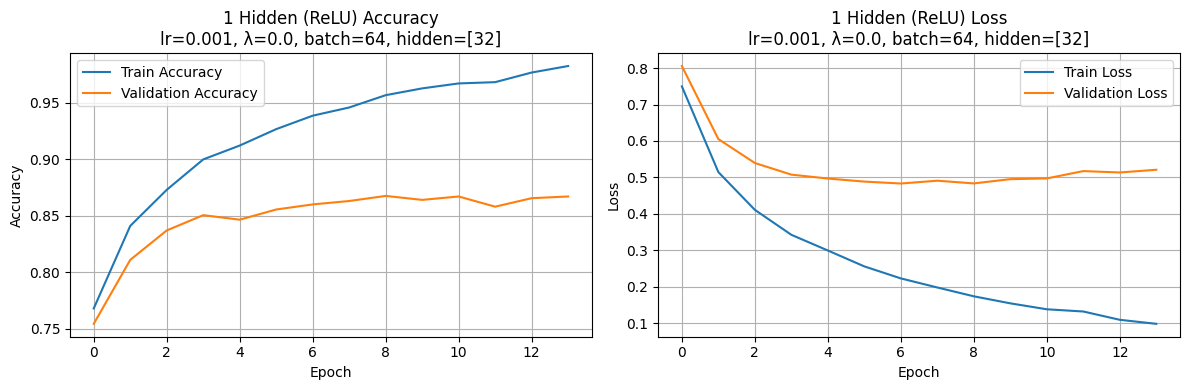

1 Hidden (ReLU) | Config: [64], Val Accuracy: 0.8820


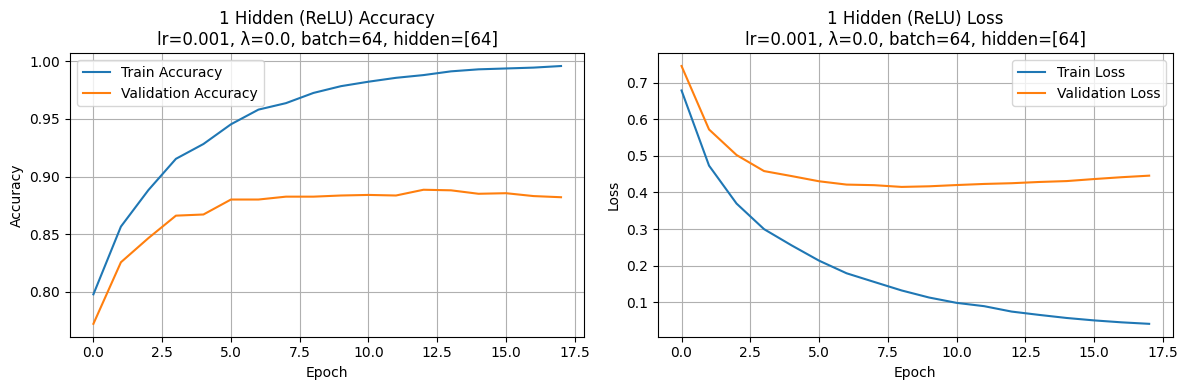

1 Hidden (ReLU) | Config: [128], Val Accuracy: 0.8935


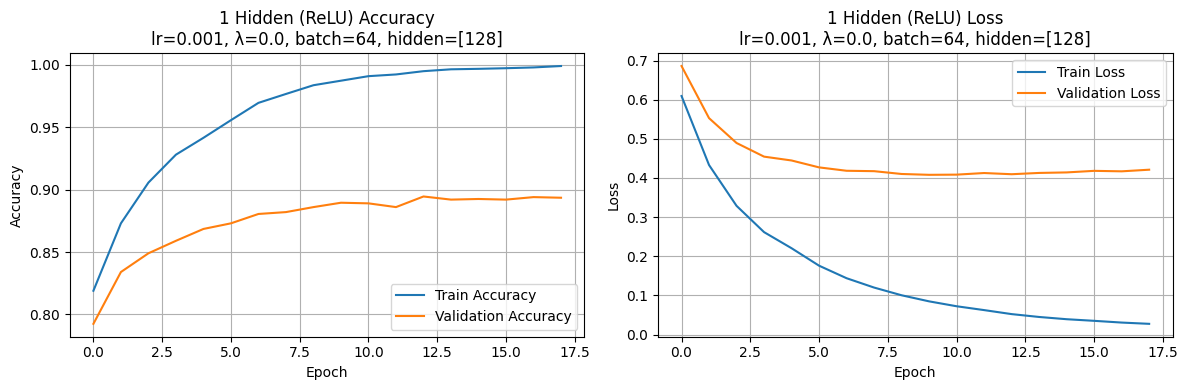

1 Hidden (ReLU) | Config: [256], Val Accuracy: 0.8880


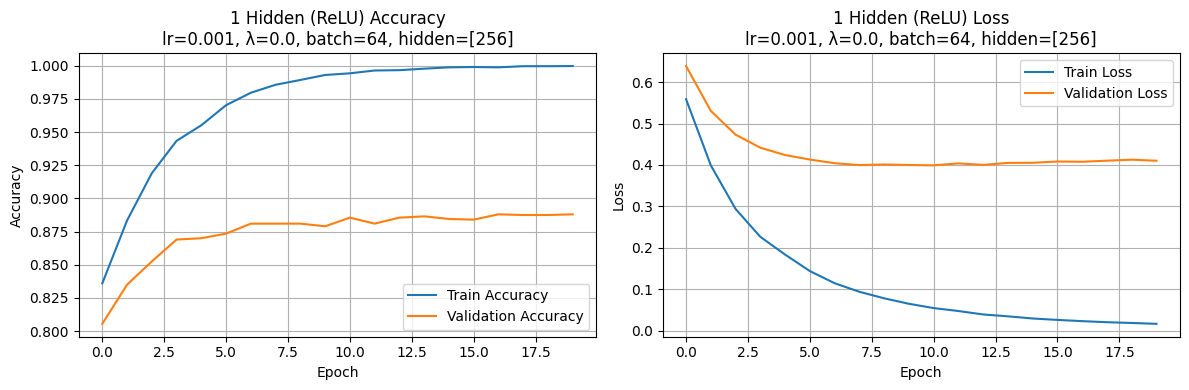

1 Hidden (ReLU) | Config: [32], Val Accuracy: 0.8670


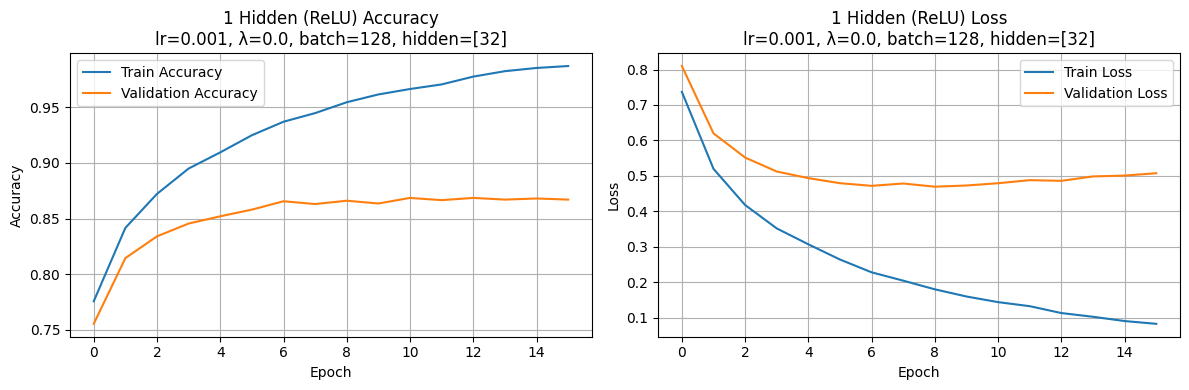

1 Hidden (ReLU) | Config: [64], Val Accuracy: 0.8825


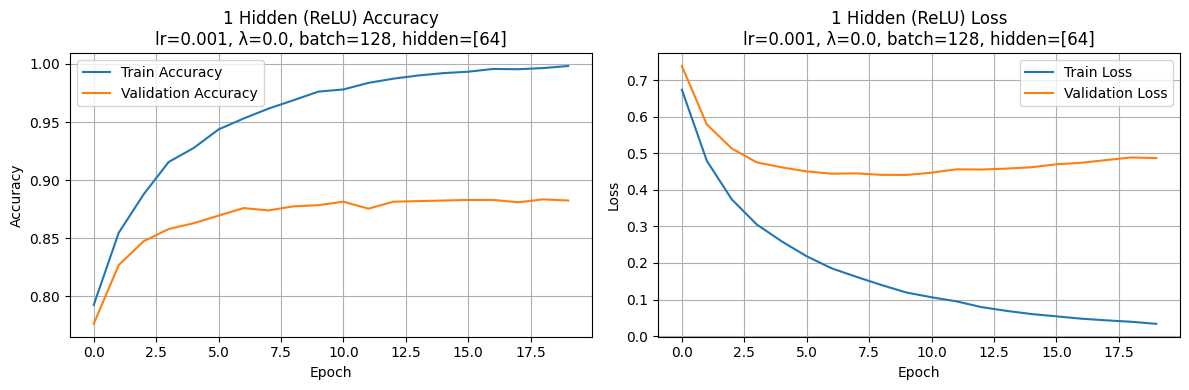

1 Hidden (ReLU) | Config: [128], Val Accuracy: 0.8925


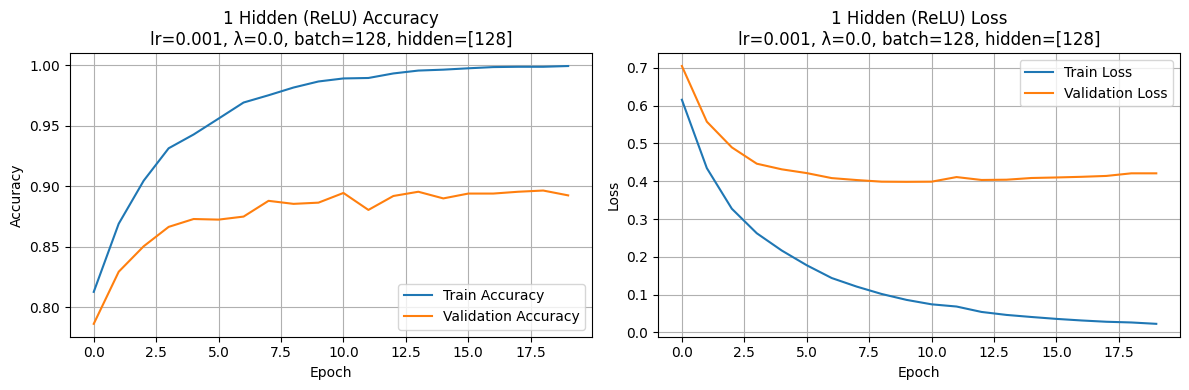

1 Hidden (ReLU) | Config: [256], Val Accuracy: 0.8970


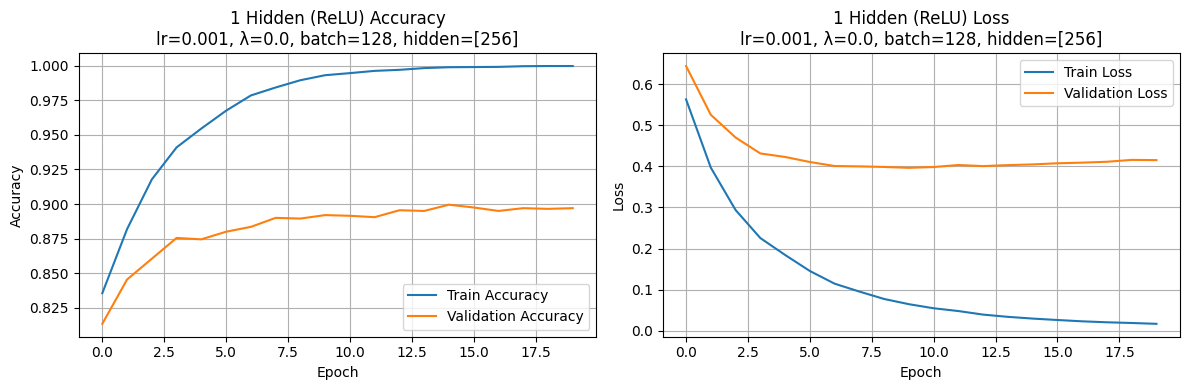

1 Hidden (ReLU) | Config: [32], Val Accuracy: 0.8660


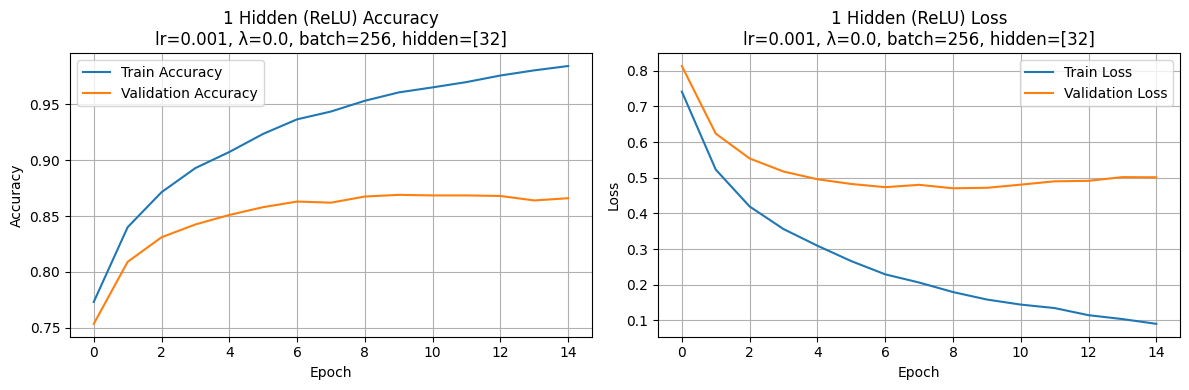

1 Hidden (ReLU) | Config: [64], Val Accuracy: 0.8845


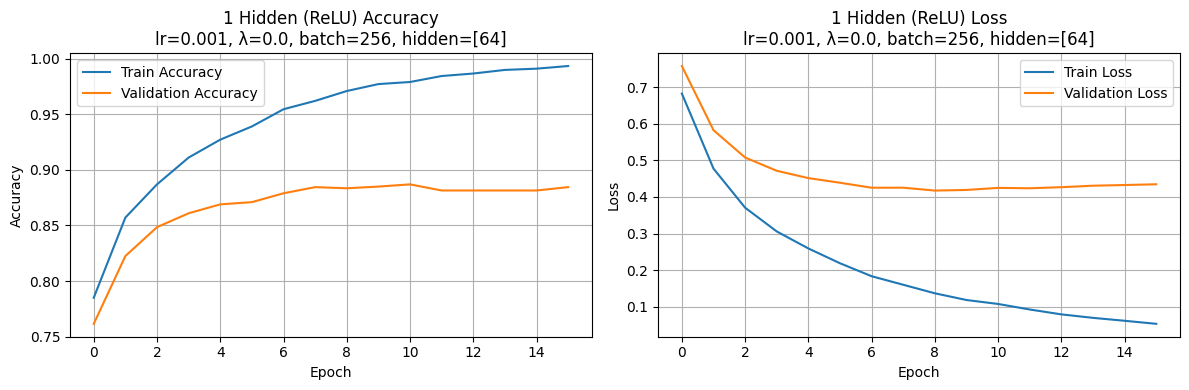

1 Hidden (ReLU) | Config: [128], Val Accuracy: 0.8920


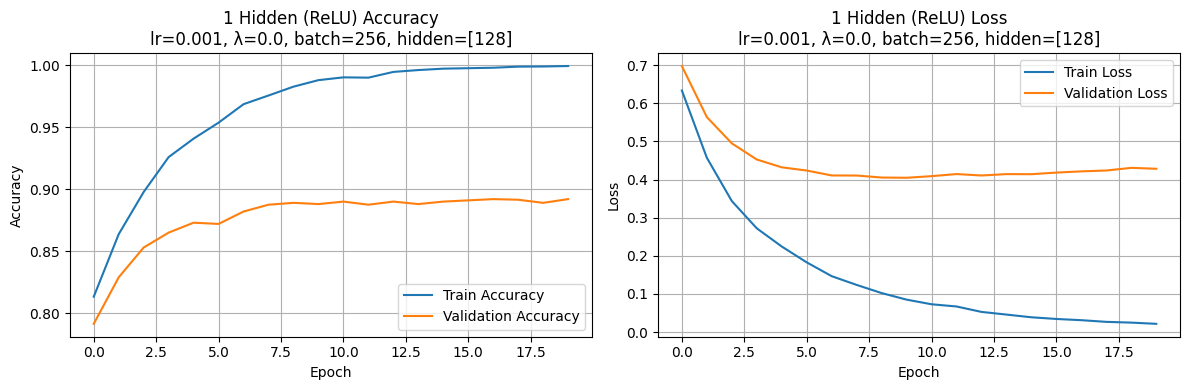

1 Hidden (ReLU) | Config: [256], Val Accuracy: 0.8985


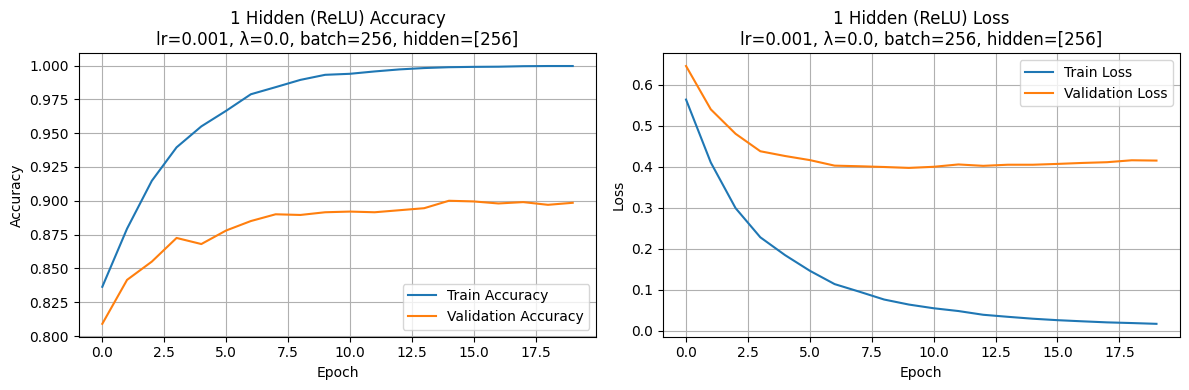

1 Hidden (ReLU) | Config: [32], Val Accuracy: 0.8700


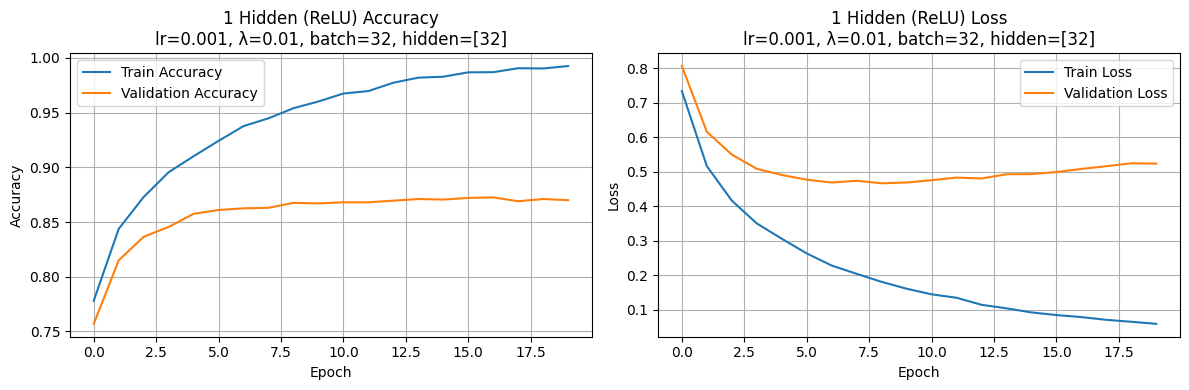

1 Hidden (ReLU) | Config: [64], Val Accuracy: 0.8845


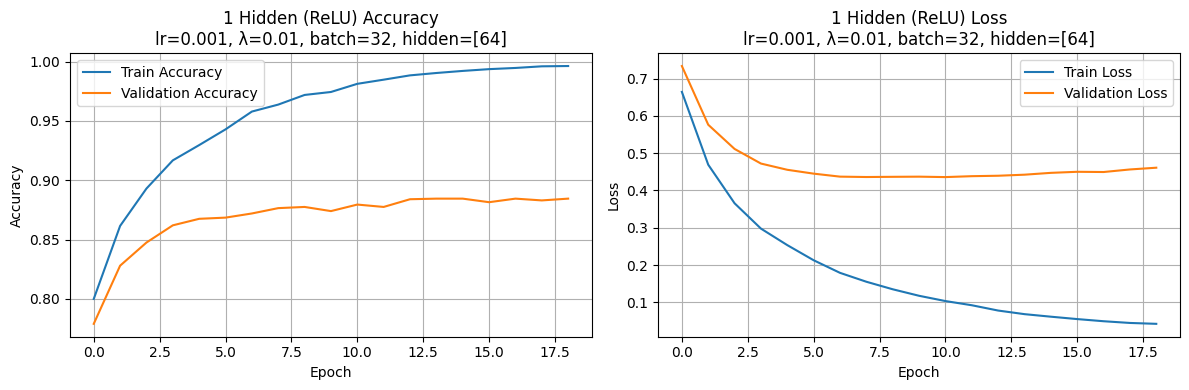

1 Hidden (ReLU) | Config: [128], Val Accuracy: 0.8905


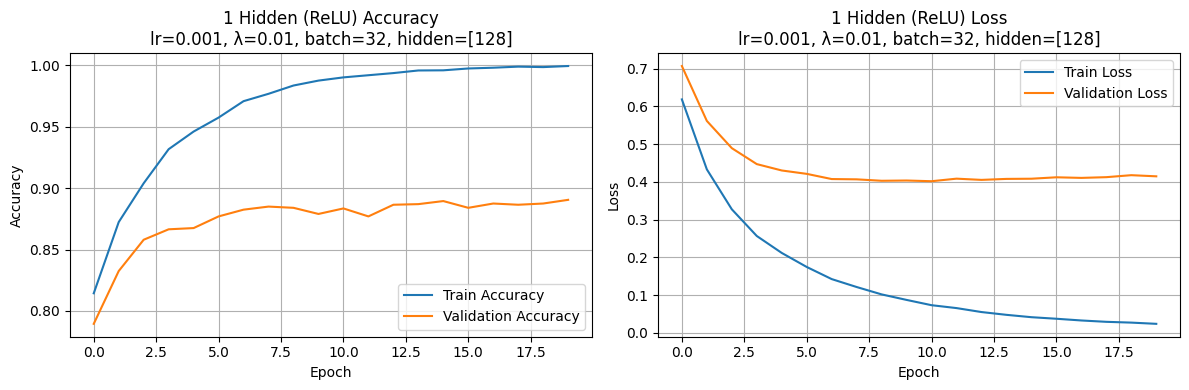

1 Hidden (ReLU) | Config: [256], Val Accuracy: 0.8975


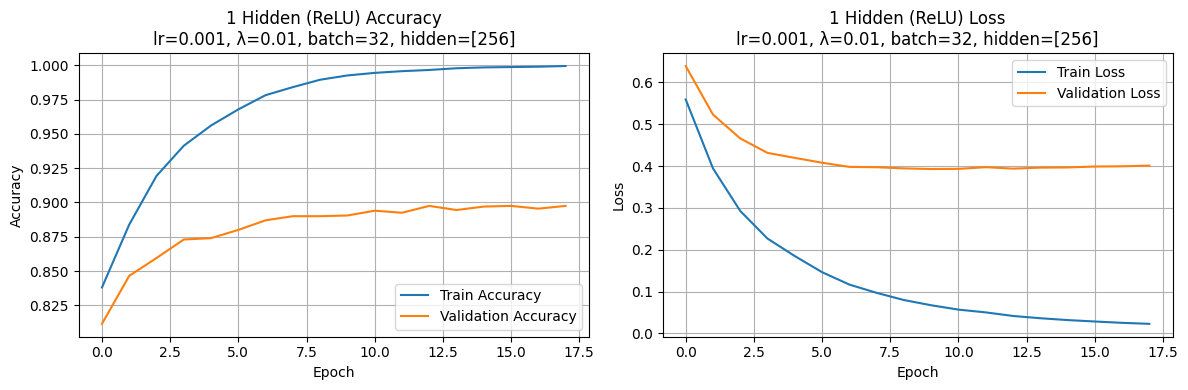

1 Hidden (ReLU) | Config: [32], Val Accuracy: 0.8615


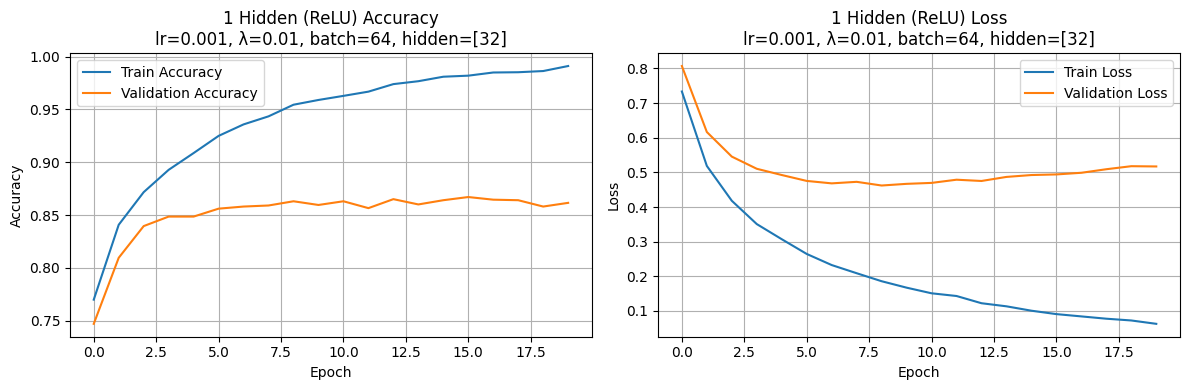

1 Hidden (ReLU) | Config: [64], Val Accuracy: 0.8845


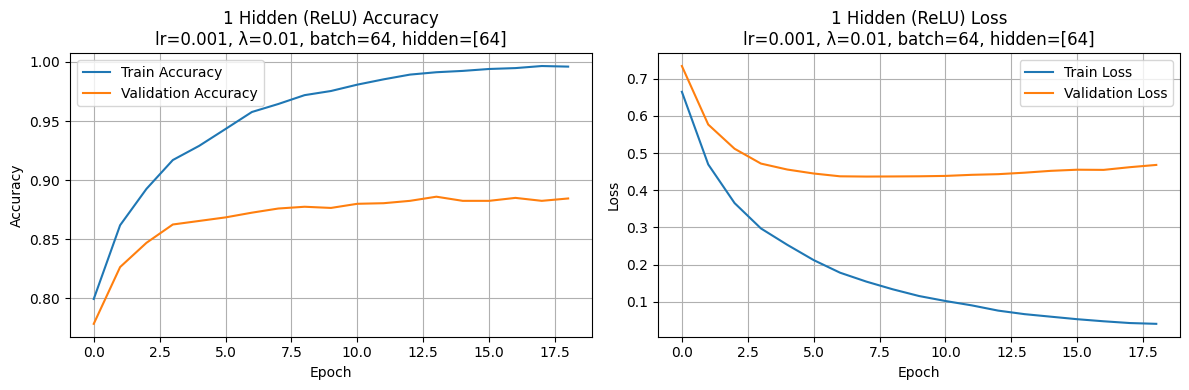

1 Hidden (ReLU) | Config: [128], Val Accuracy: 0.8890


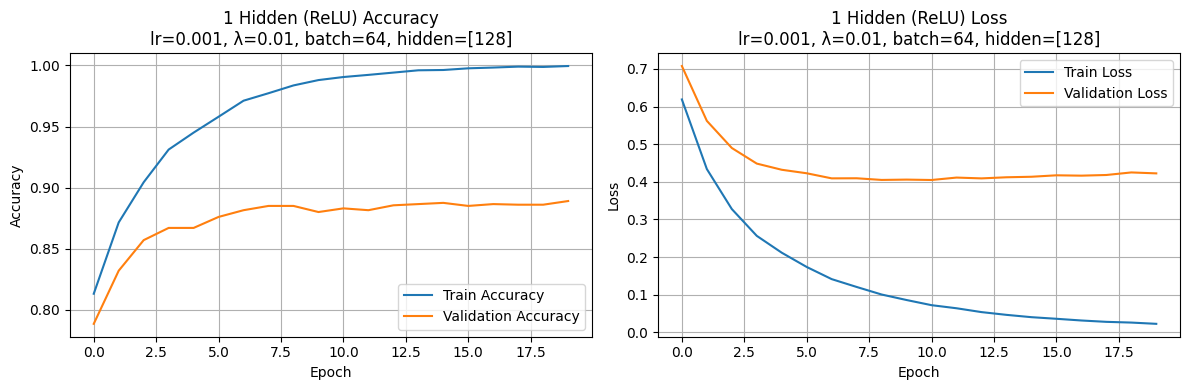

1 Hidden (ReLU) | Config: [256], Val Accuracy: 0.8970


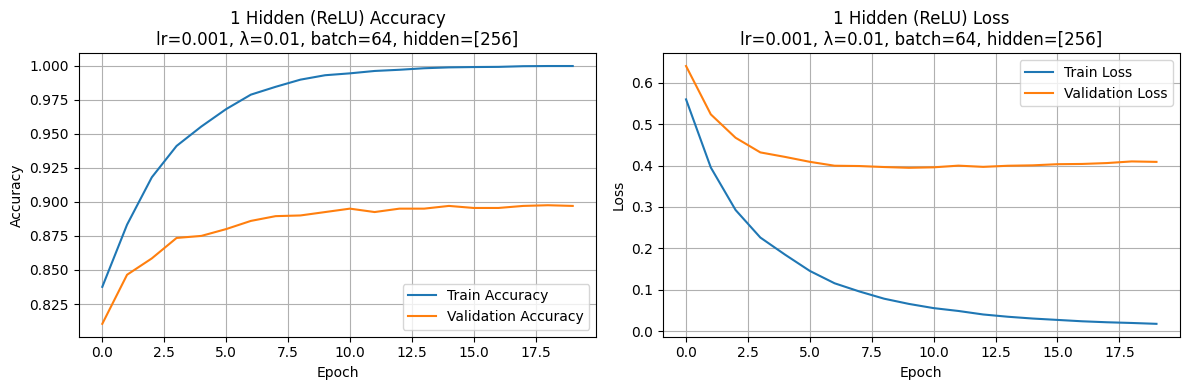

1 Hidden (ReLU) | Config: [32], Val Accuracy: 0.8710


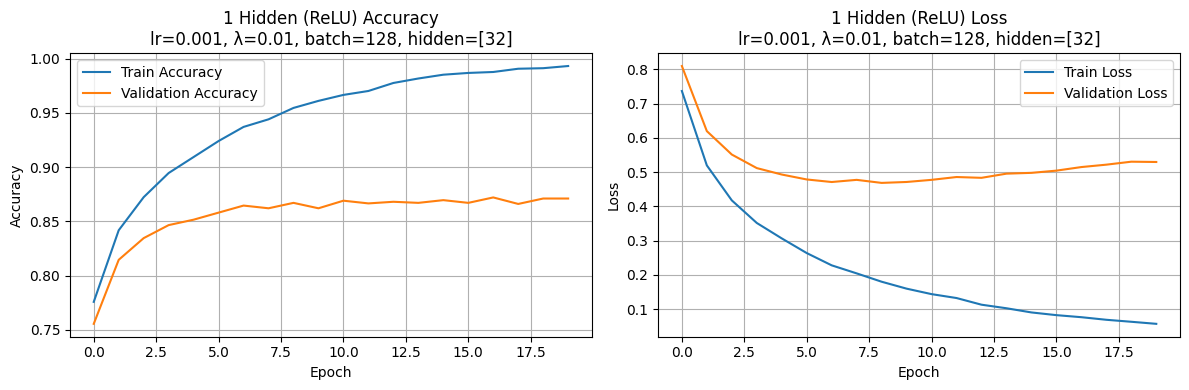

1 Hidden (ReLU) | Config: [64], Val Accuracy: 0.8855


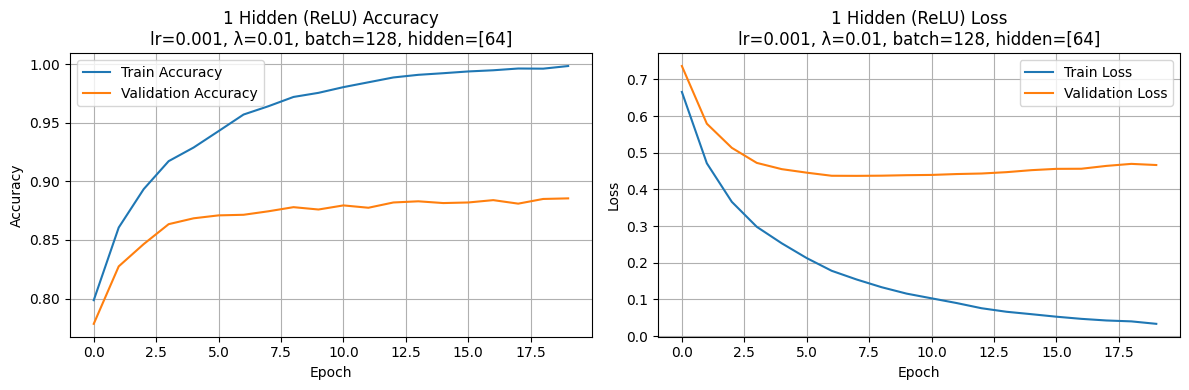

1 Hidden (ReLU) | Config: [128], Val Accuracy: 0.8935


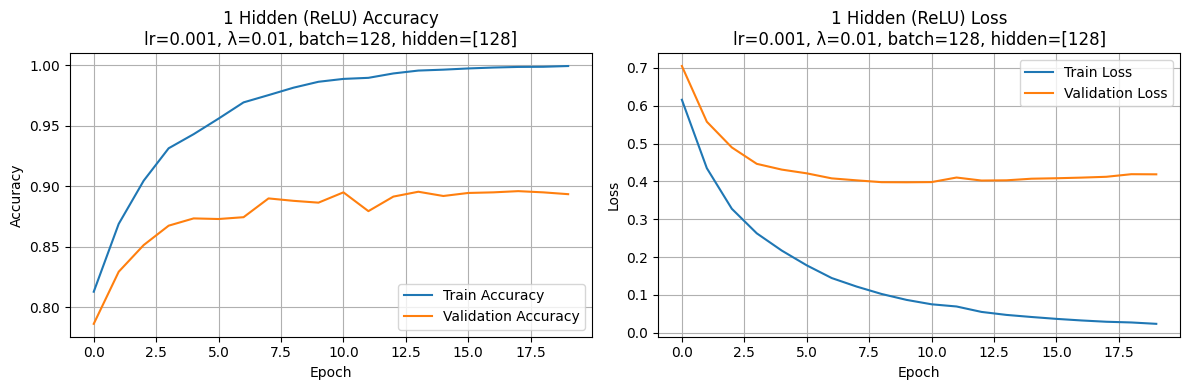

1 Hidden (ReLU) | Config: [256], Val Accuracy: 0.8970


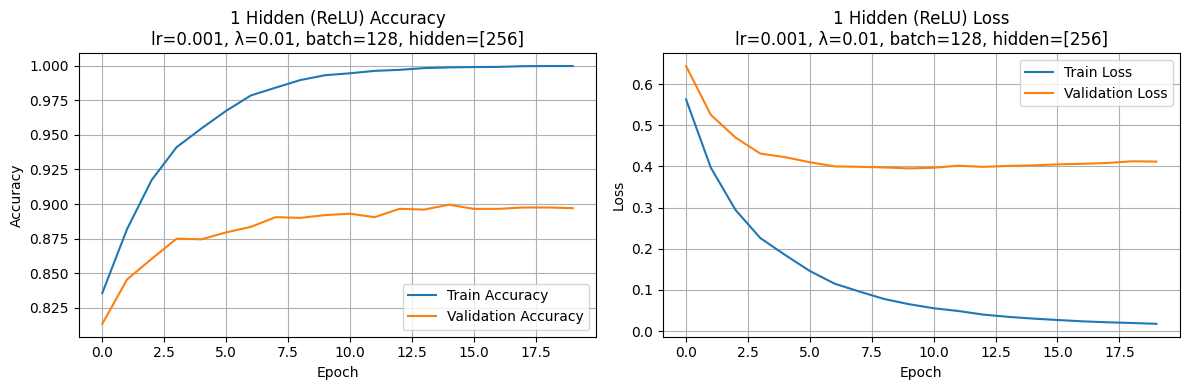

1 Hidden (ReLU) | Config: [32], Val Accuracy: 0.8685


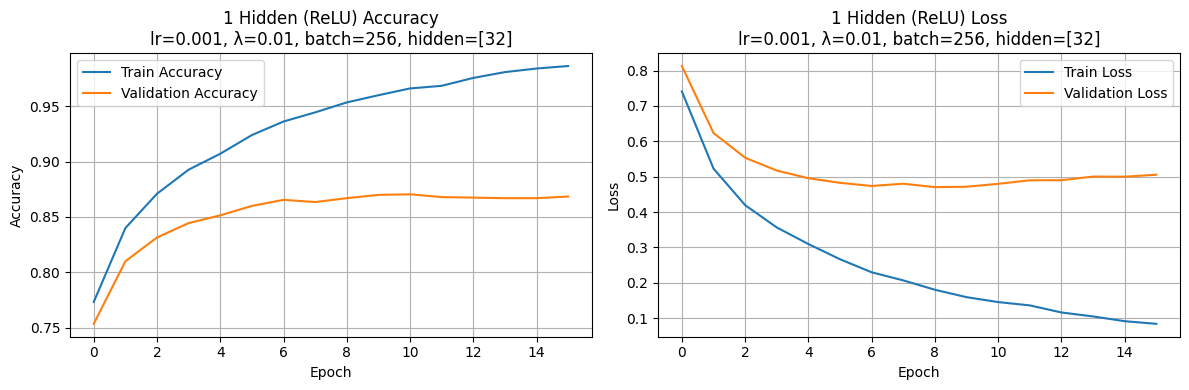

1 Hidden (ReLU) | Config: [64], Val Accuracy: 0.8810


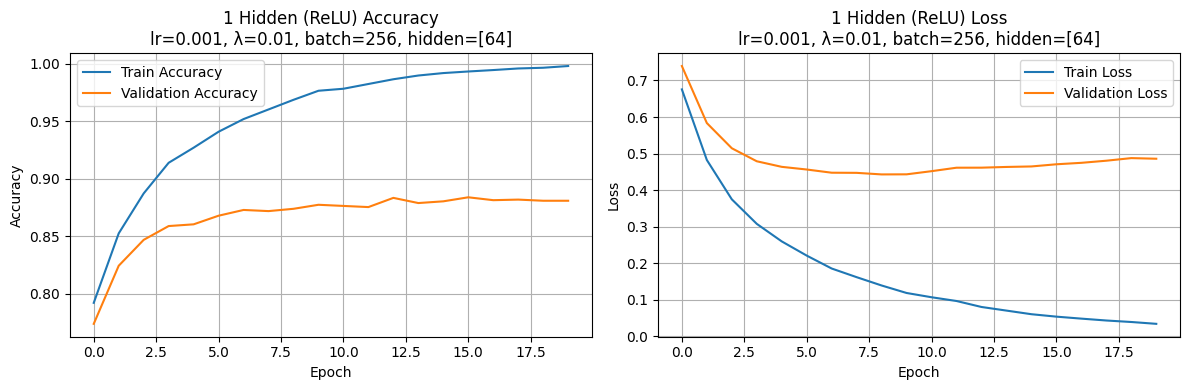

1 Hidden (ReLU) | Config: [128], Val Accuracy: 0.8940


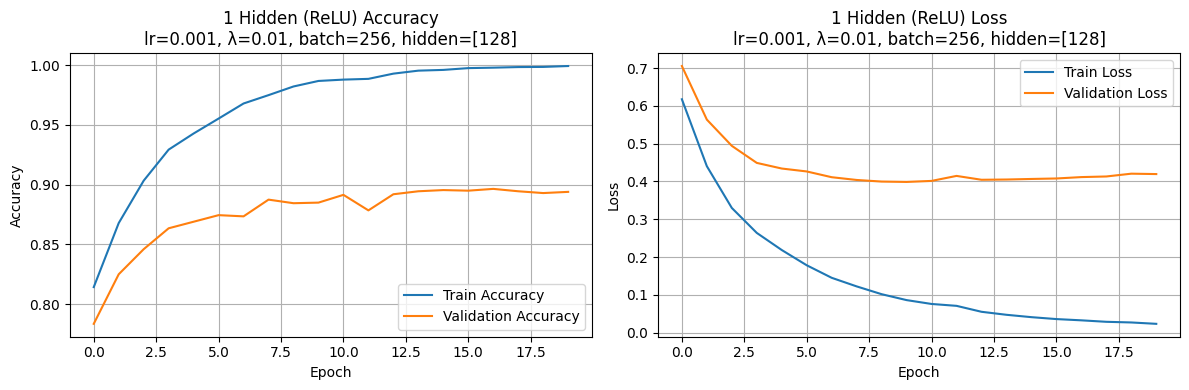

1 Hidden (ReLU) | Config: [256], Val Accuracy: 0.8985


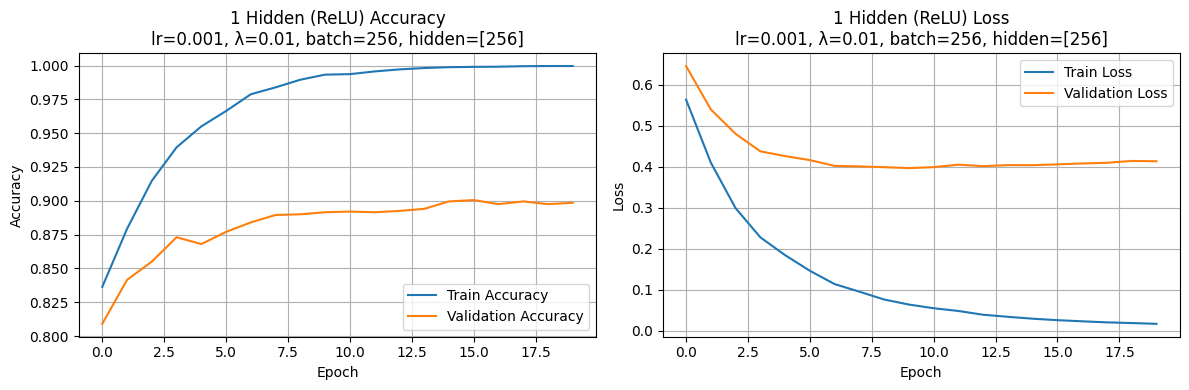

1 Hidden (ReLU) | Config: [32], Val Accuracy: 0.8190


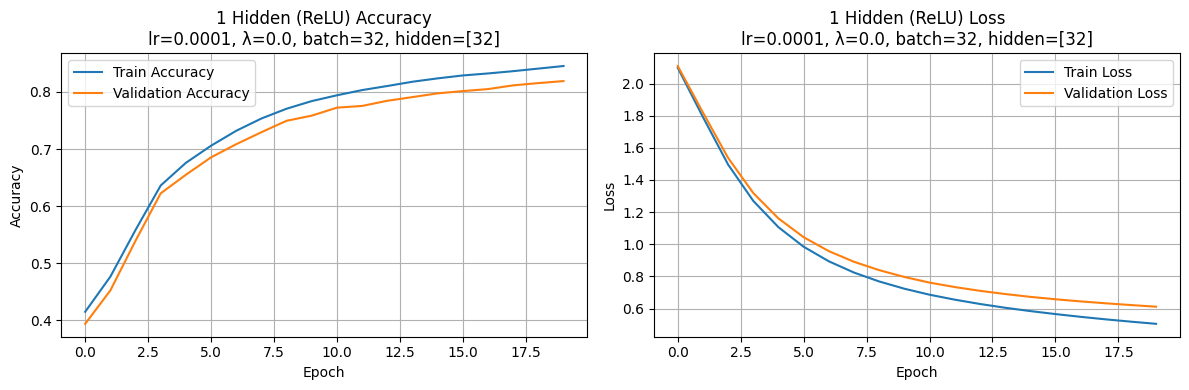

1 Hidden (ReLU) | Config: [64], Val Accuracy: 0.8325


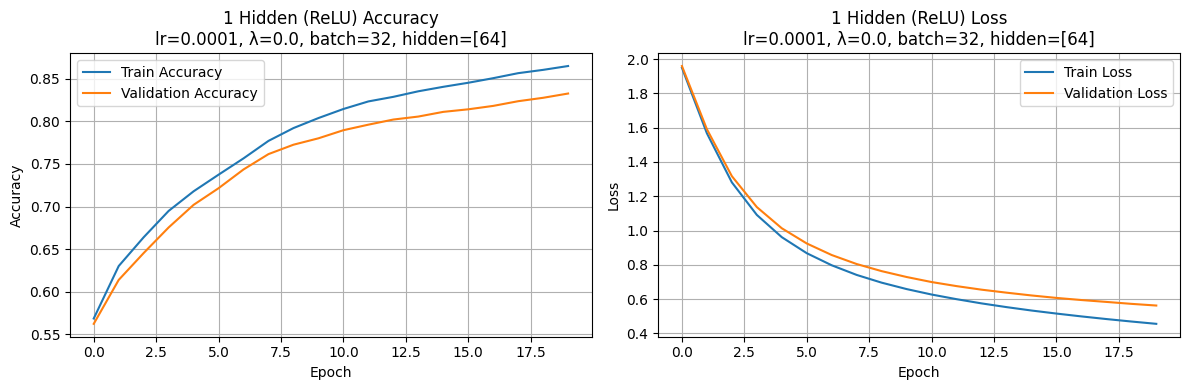

1 Hidden (ReLU) | Config: [128], Val Accuracy: 0.8360


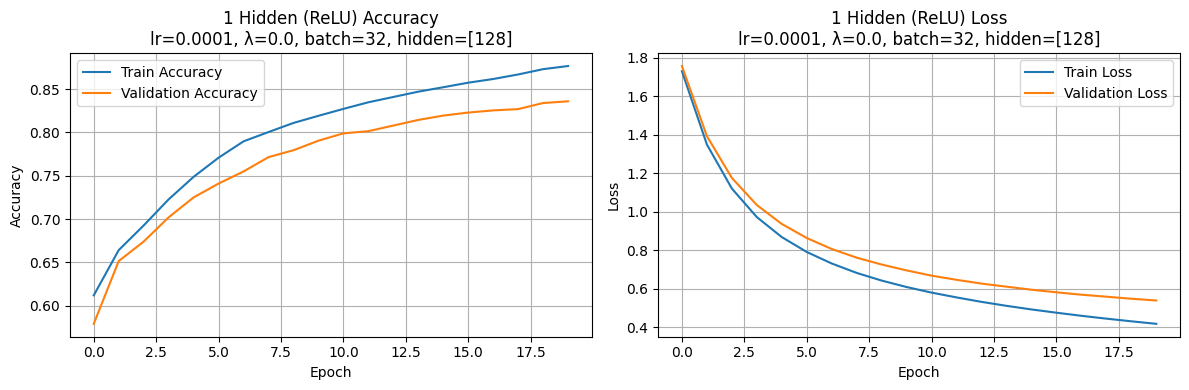

1 Hidden (ReLU) | Config: [256], Val Accuracy: 0.8495


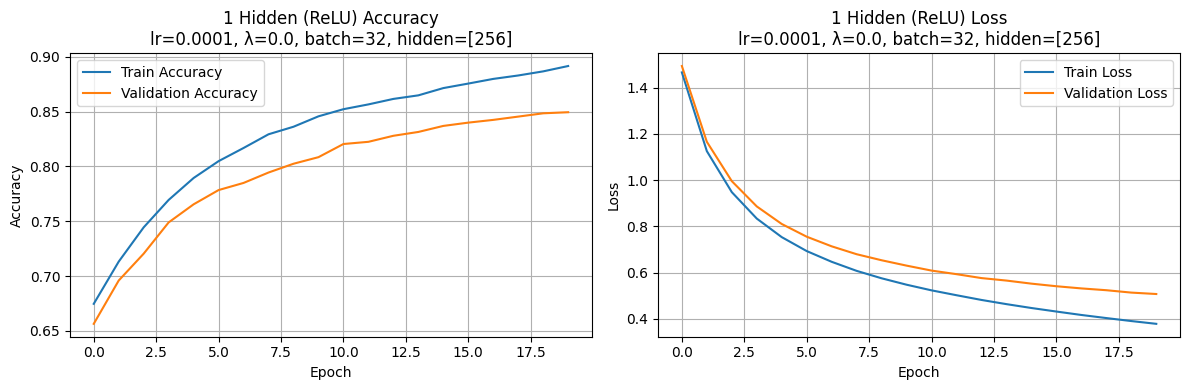

1 Hidden (ReLU) | Config: [32], Val Accuracy: 0.8190


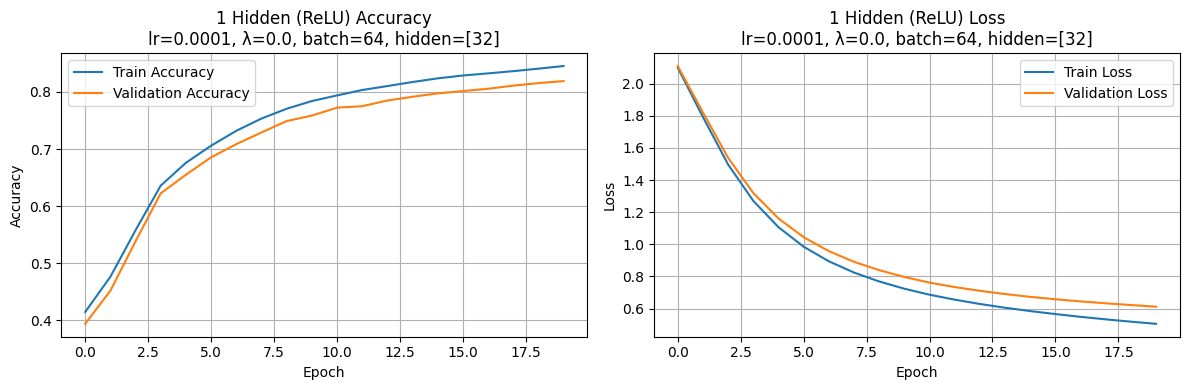

1 Hidden (ReLU) | Config: [64], Val Accuracy: 0.8325


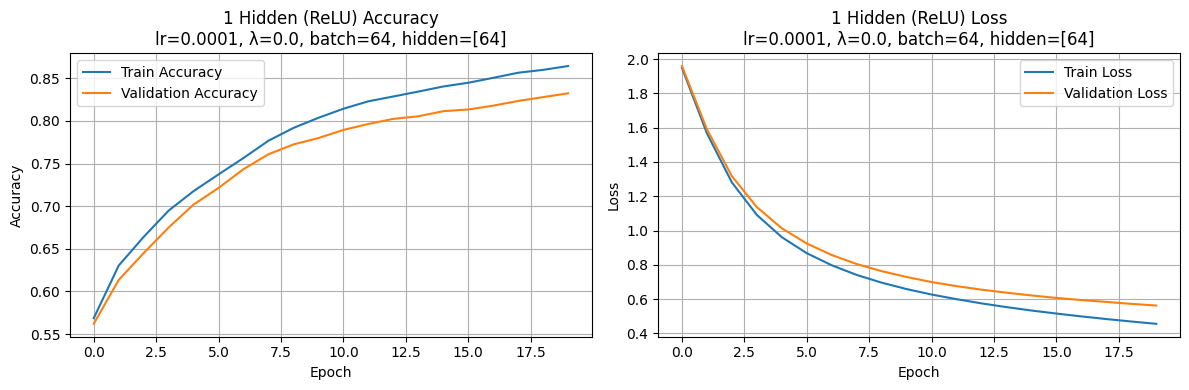

1 Hidden (ReLU) | Config: [128], Val Accuracy: 0.8360


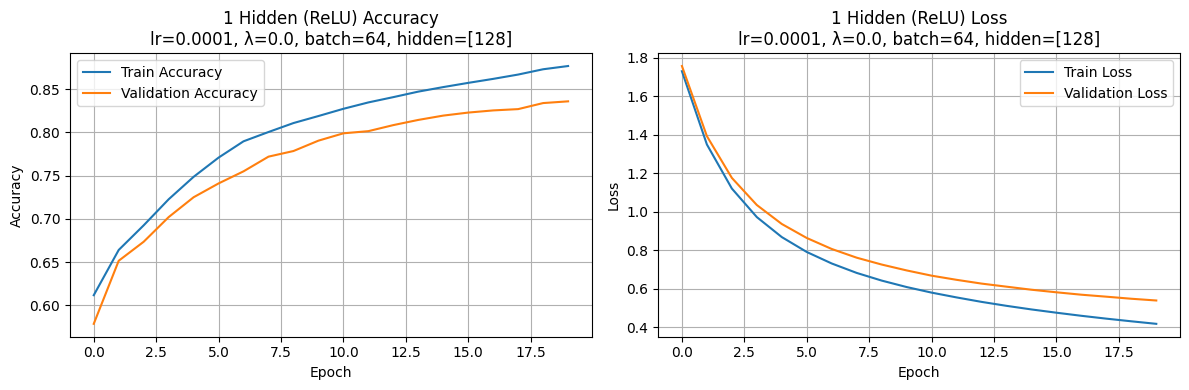

1 Hidden (ReLU) | Config: [256], Val Accuracy: 0.8495


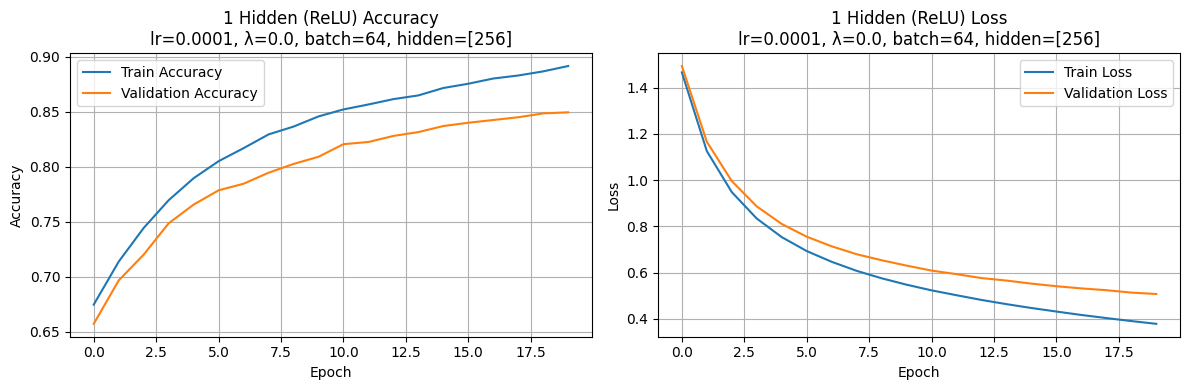

1 Hidden (ReLU) | Config: [32], Val Accuracy: 0.8190


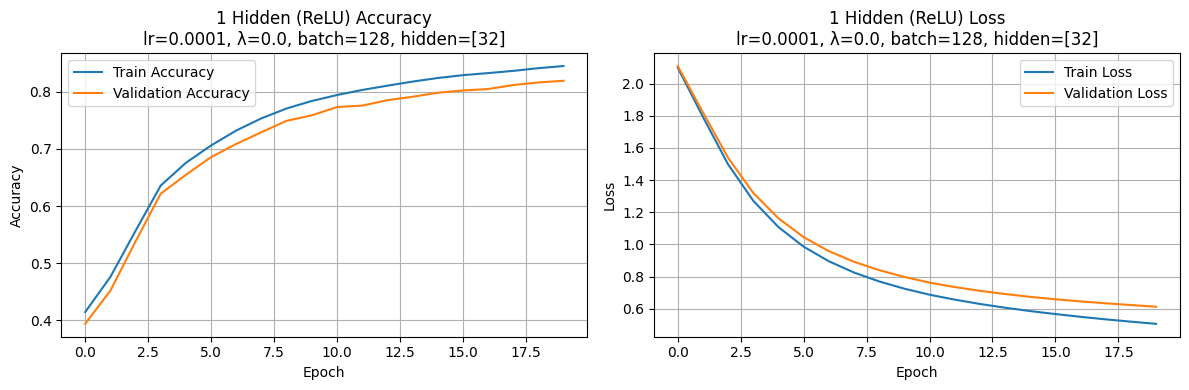

1 Hidden (ReLU) | Config: [64], Val Accuracy: 0.8320


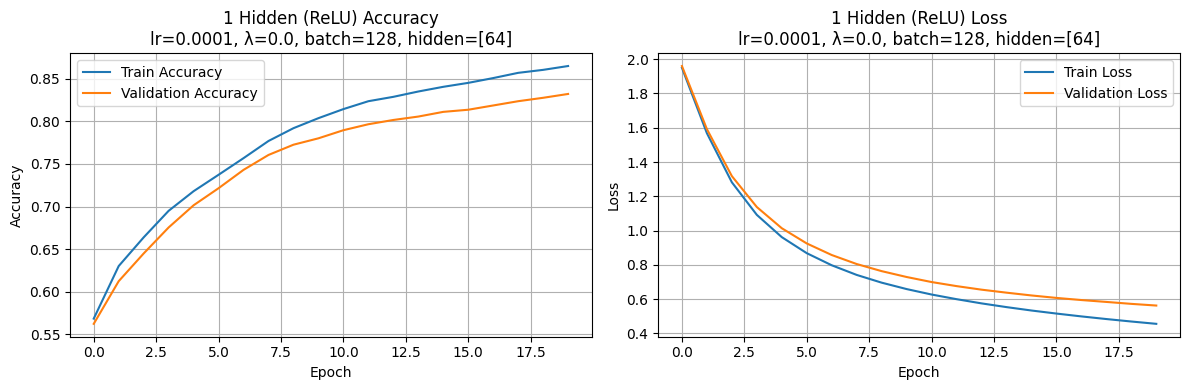

1 Hidden (ReLU) | Config: [128], Val Accuracy: 0.8360


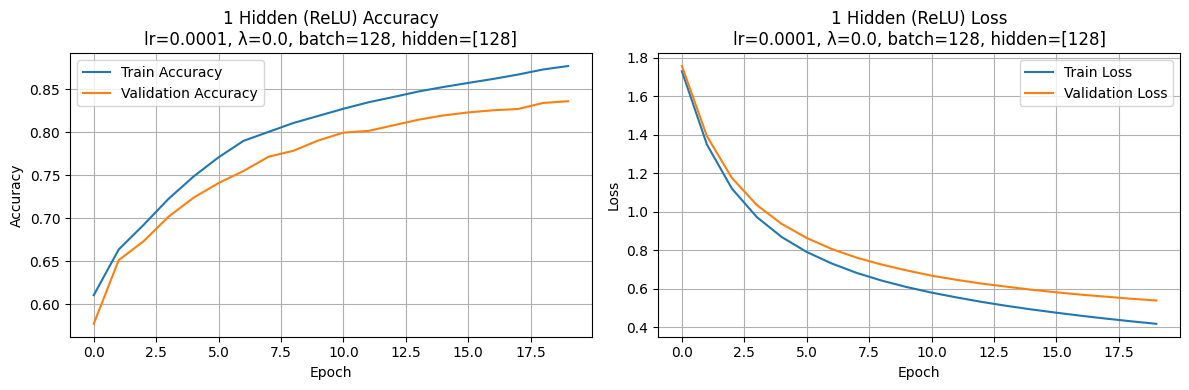

1 Hidden (ReLU) | Config: [256], Val Accuracy: 0.8480


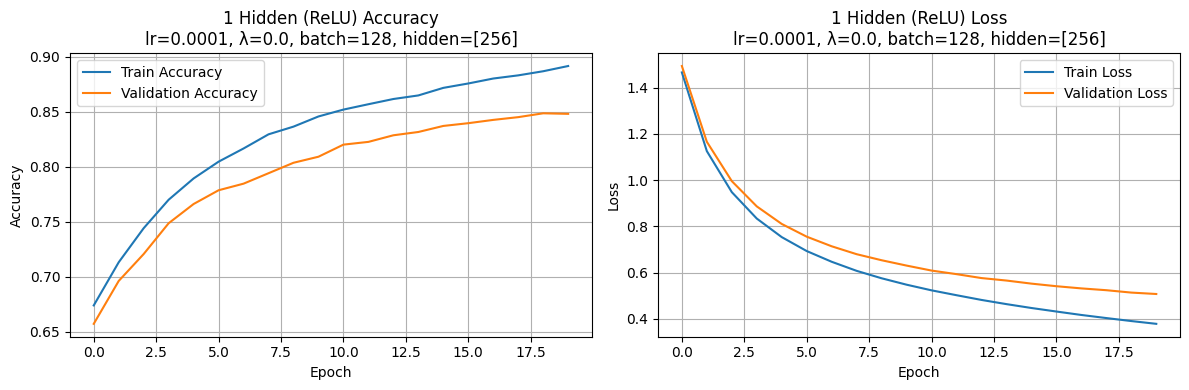

1 Hidden (ReLU) | Config: [32], Val Accuracy: 0.8190


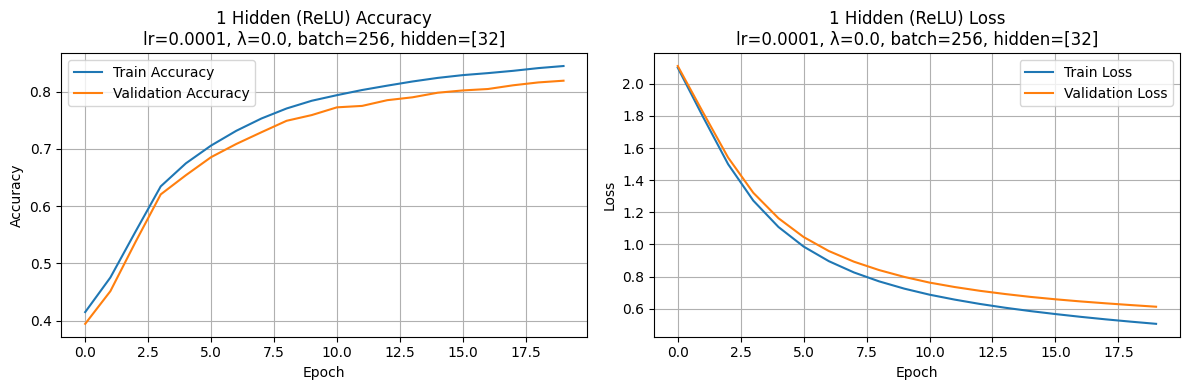

1 Hidden (ReLU) | Config: [64], Val Accuracy: 0.8315


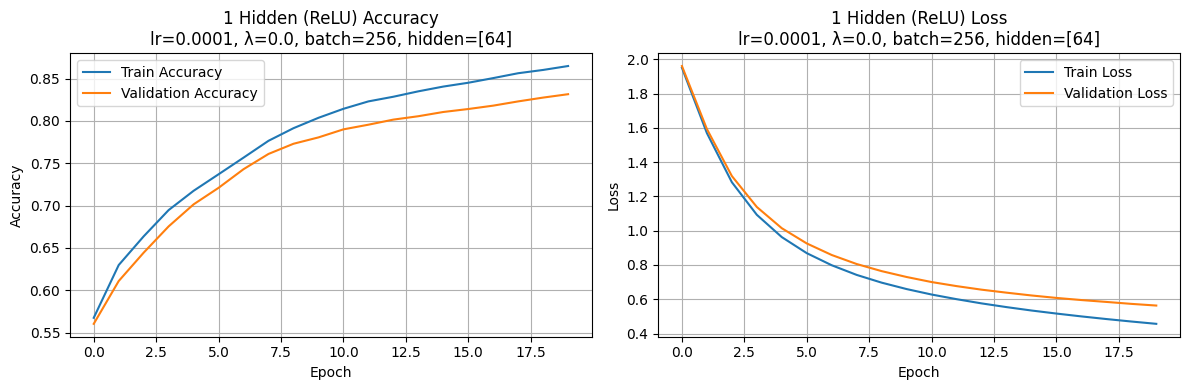

1 Hidden (ReLU) | Config: [128], Val Accuracy: 0.8365


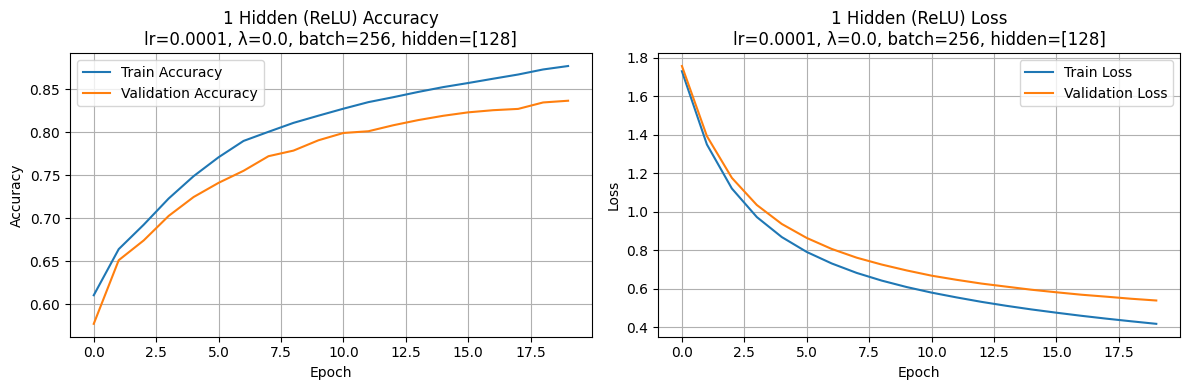

1 Hidden (ReLU) | Config: [256], Val Accuracy: 0.8480


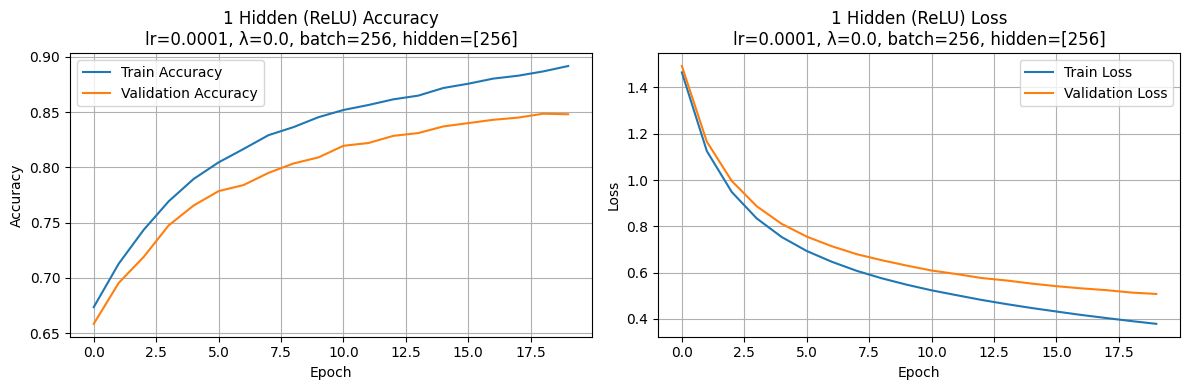

1 Hidden (ReLU) | Config: [32], Val Accuracy: 0.8190


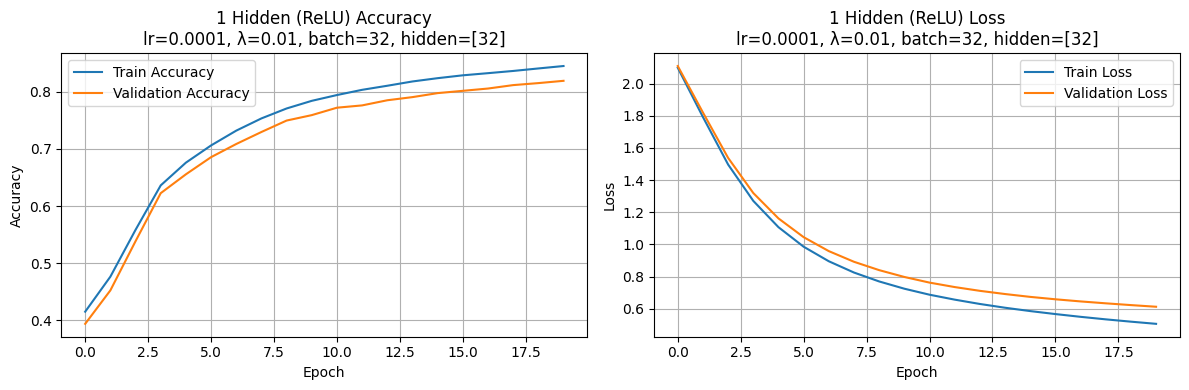

1 Hidden (ReLU) | Config: [64], Val Accuracy: 0.8320


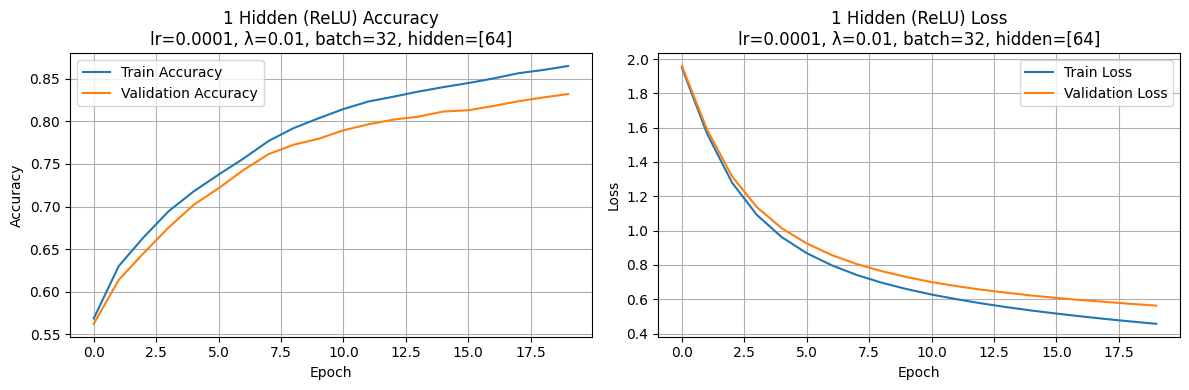

1 Hidden (ReLU) | Config: [128], Val Accuracy: 0.8360


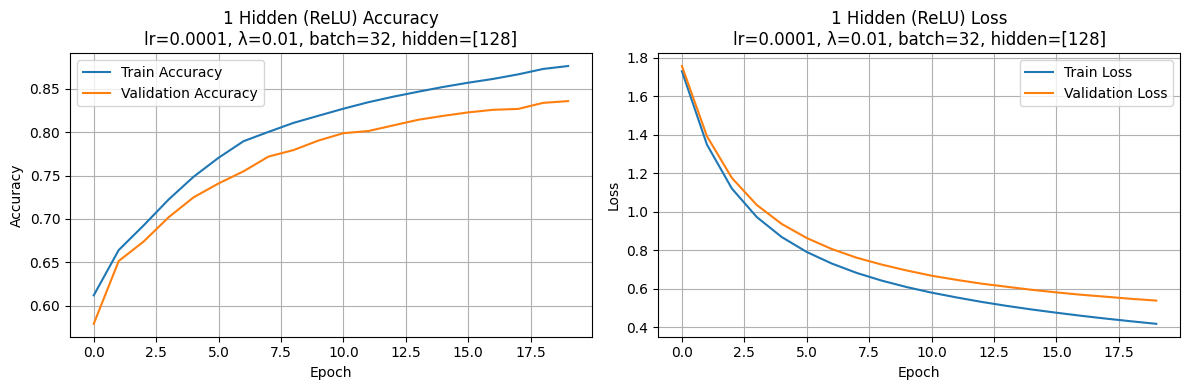

1 Hidden (ReLU) | Config: [256], Val Accuracy: 0.8495


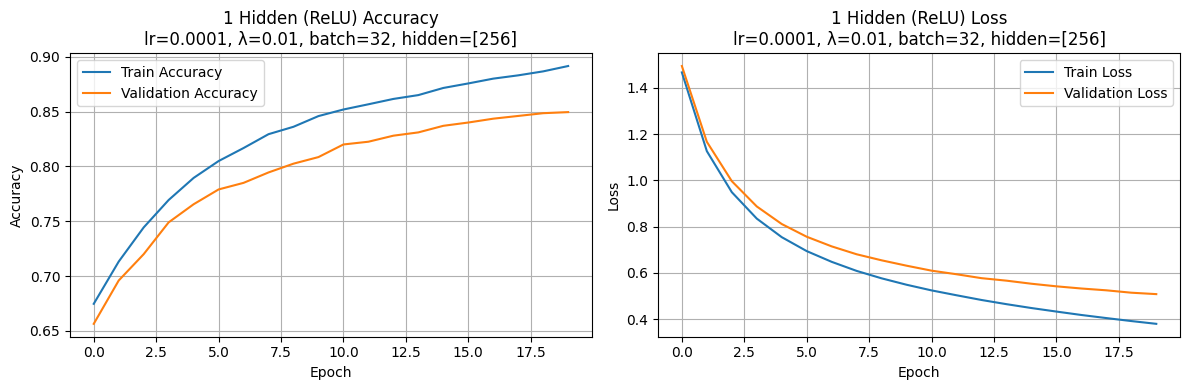

1 Hidden (ReLU) | Config: [32], Val Accuracy: 0.8190


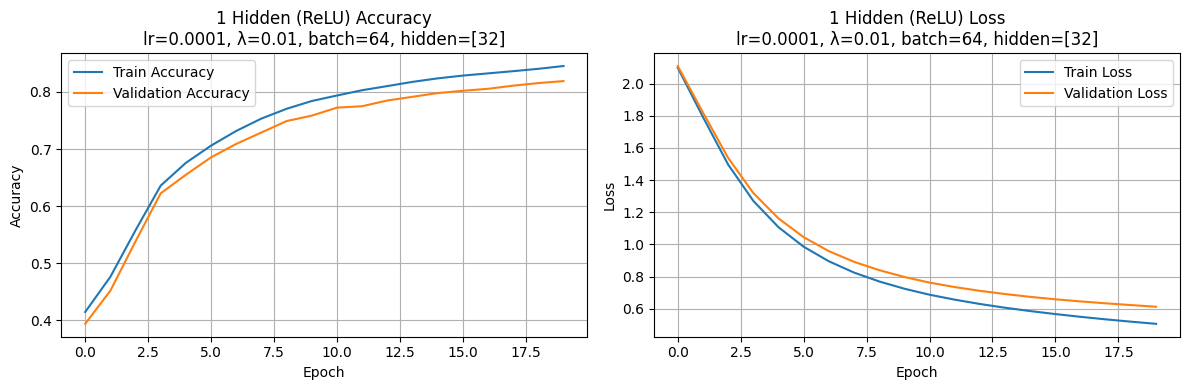

1 Hidden (ReLU) | Config: [64], Val Accuracy: 0.8325


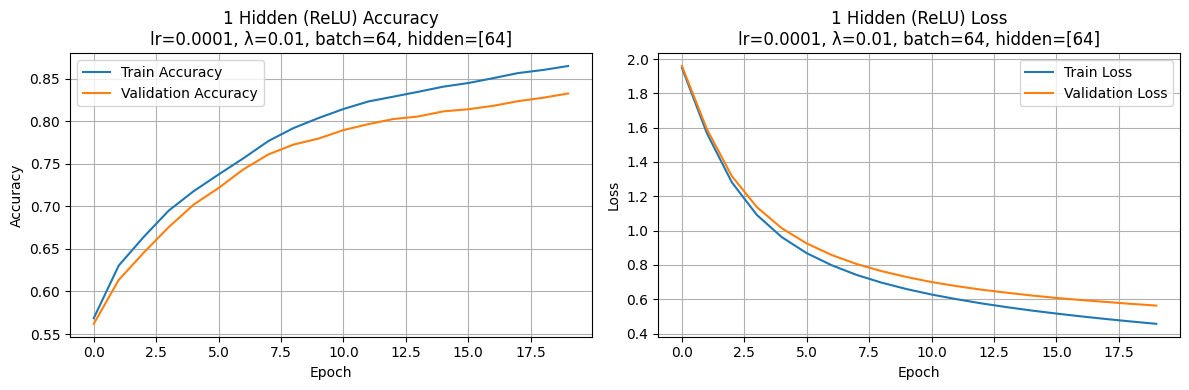

1 Hidden (ReLU) | Config: [128], Val Accuracy: 0.8360


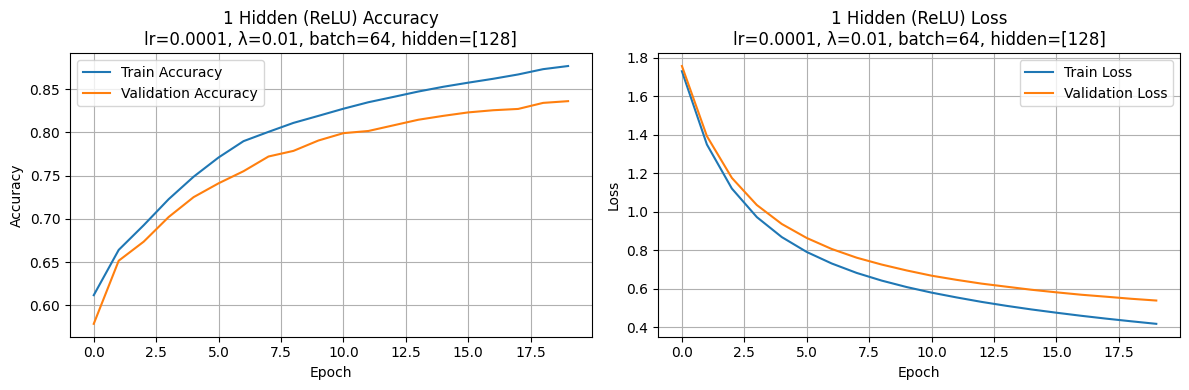

1 Hidden (ReLU) | Config: [256], Val Accuracy: 0.8495


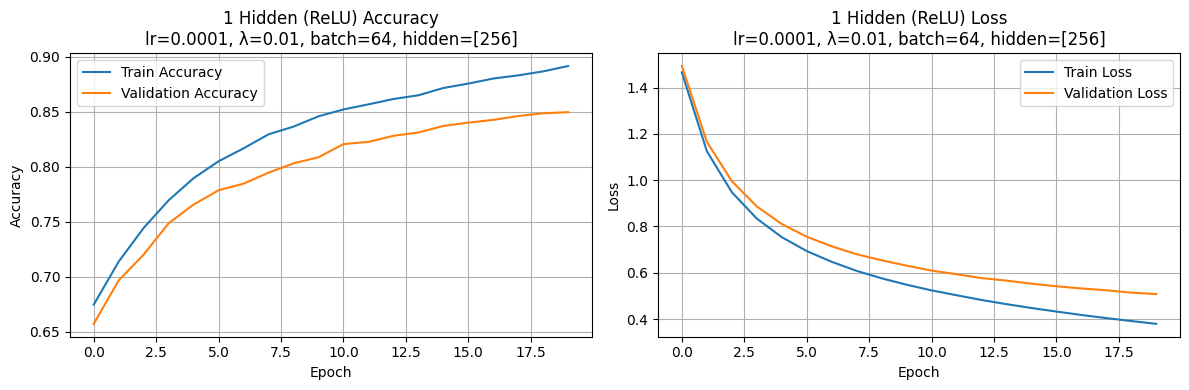

1 Hidden (ReLU) | Config: [32], Val Accuracy: 0.8190


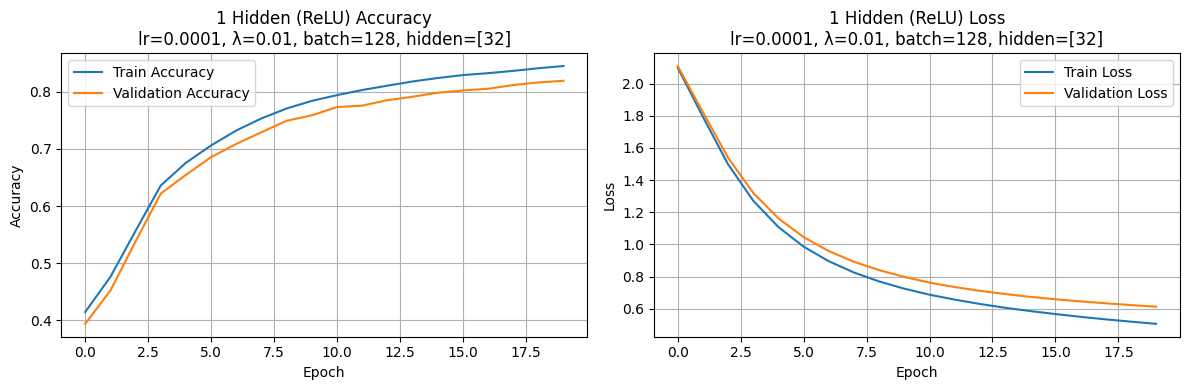

1 Hidden (ReLU) | Config: [64], Val Accuracy: 0.8315


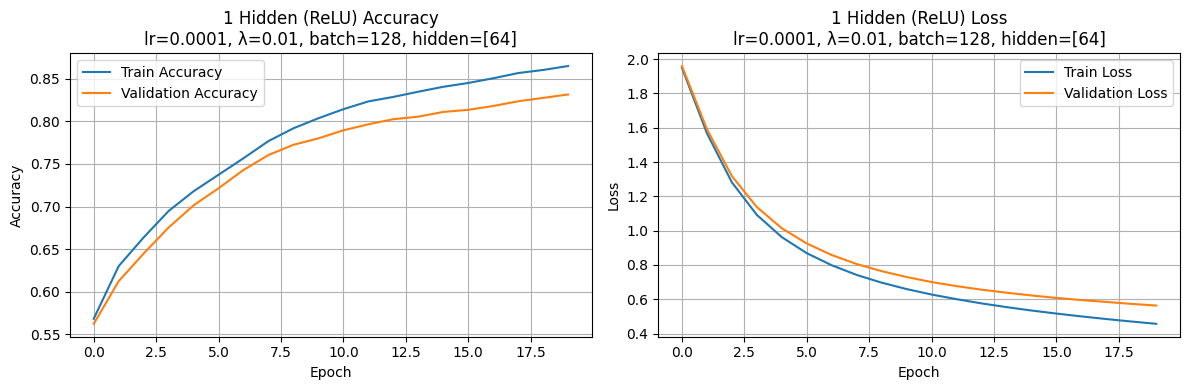

1 Hidden (ReLU) | Config: [128], Val Accuracy: 0.8360


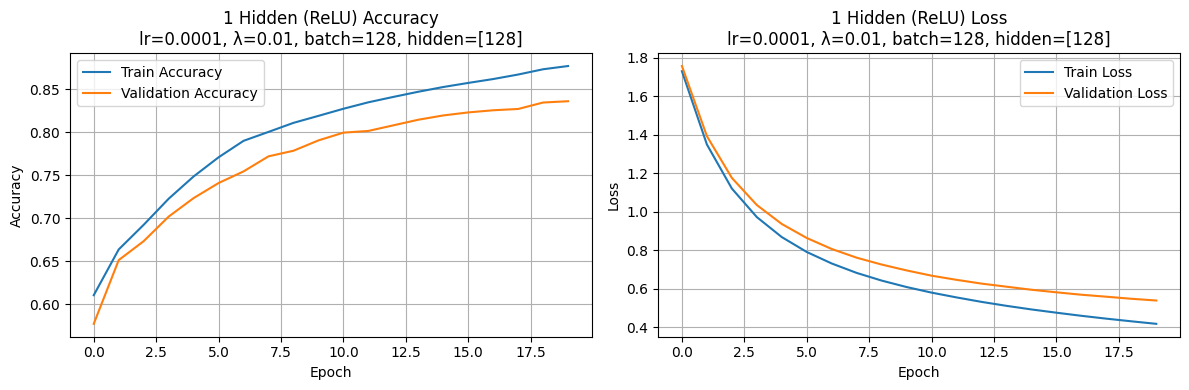

1 Hidden (ReLU) | Config: [256], Val Accuracy: 0.8480


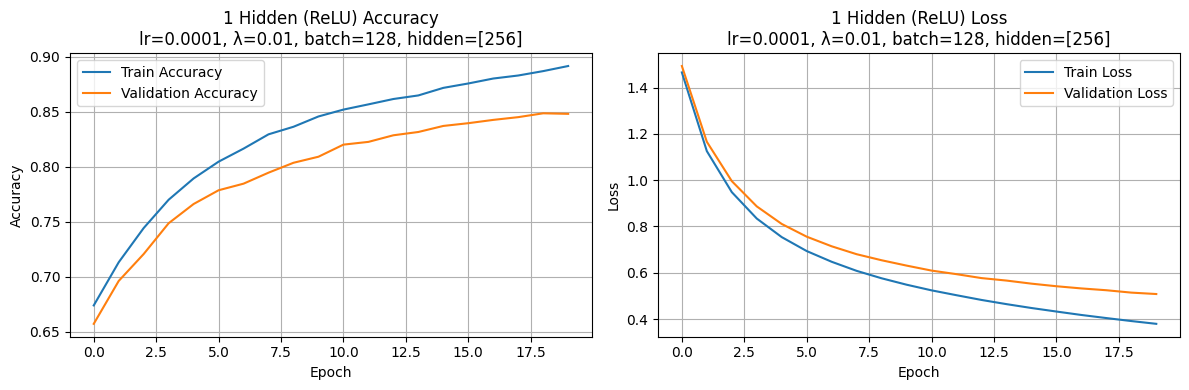

1 Hidden (ReLU) | Config: [32], Val Accuracy: 0.8190


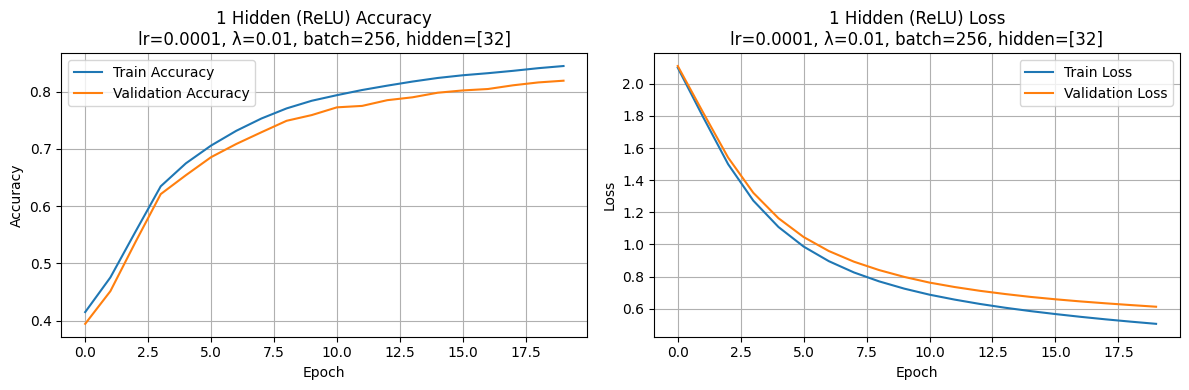

1 Hidden (ReLU) | Config: [64], Val Accuracy: 0.8315


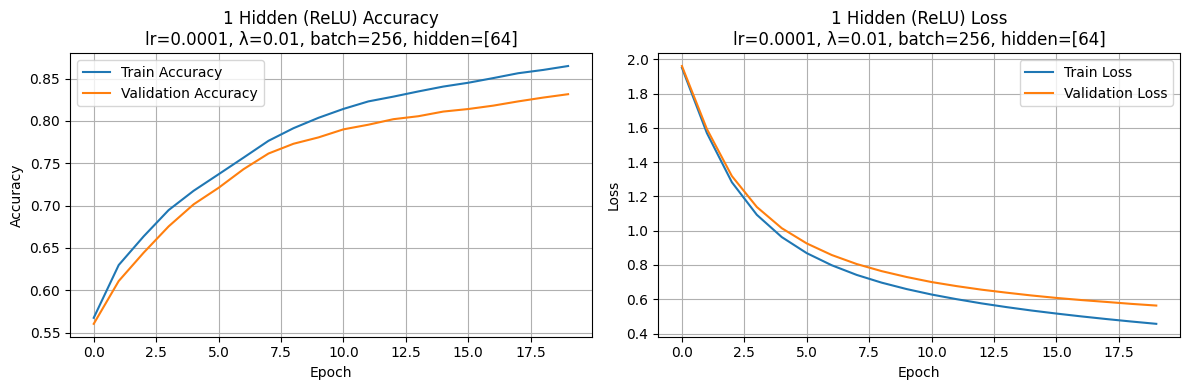

1 Hidden (ReLU) | Config: [128], Val Accuracy: 0.8365


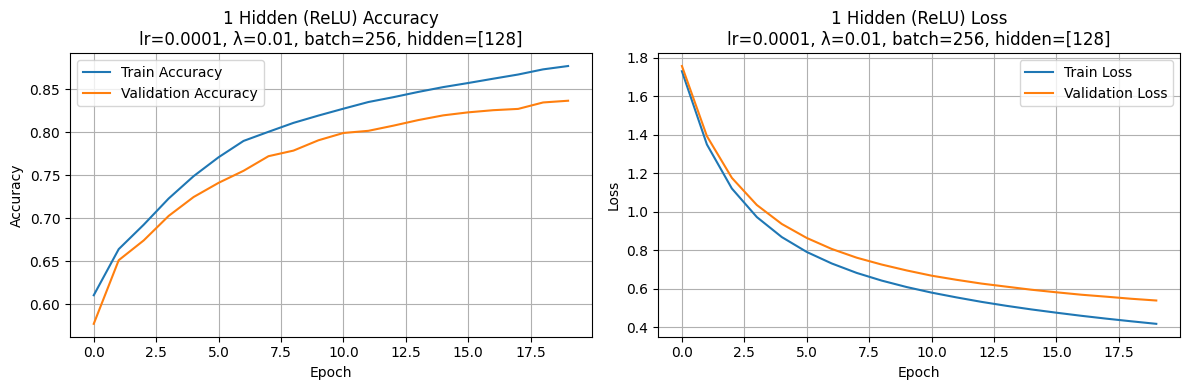

1 Hidden (ReLU) | Config: [256], Val Accuracy: 0.8480


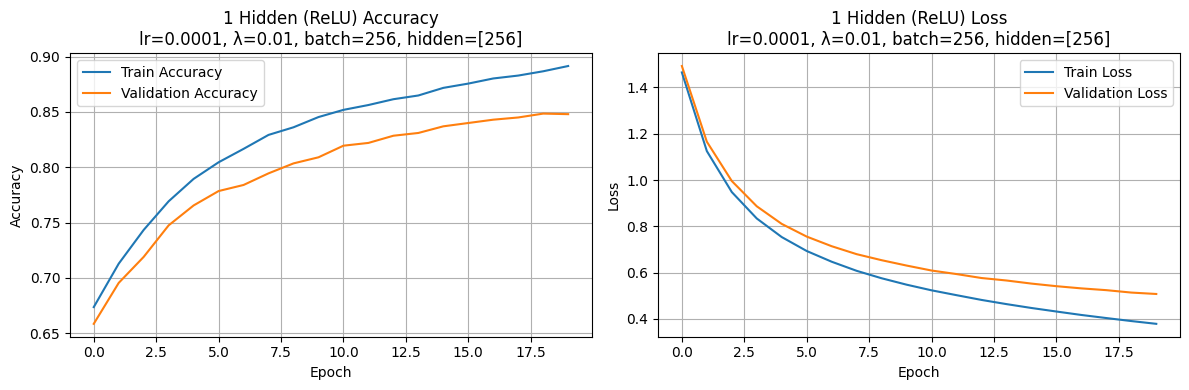


Best Result for 1 Hidden (ReLU):
 - Hidden Units: [256]
 - Learning Rate: 0.001
 - Lambda: 0.0
 - Batch Size: 256
 - Validation Accuracy: 0.8985

=== Running experiments for: 2 Hidden (ReLU) ===
2 Hidden (ReLU) | Config: [32, 32], Val Accuracy: 0.8645


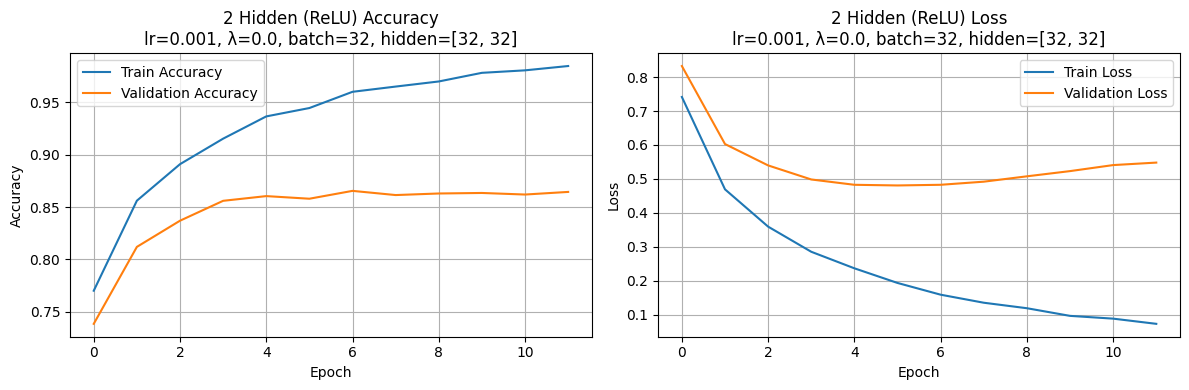

2 Hidden (ReLU) | Config: [64, 64], Val Accuracy: 0.8765


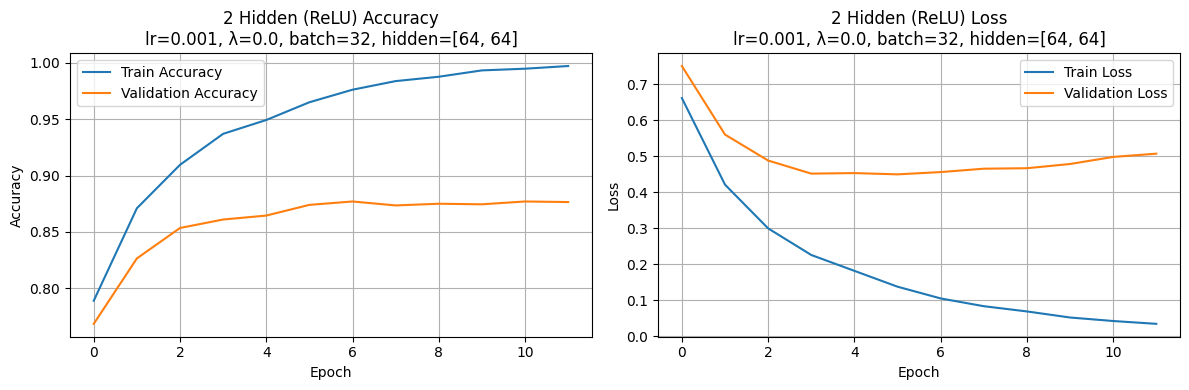

2 Hidden (ReLU) | Config: [128, 128], Val Accuracy: 0.8870


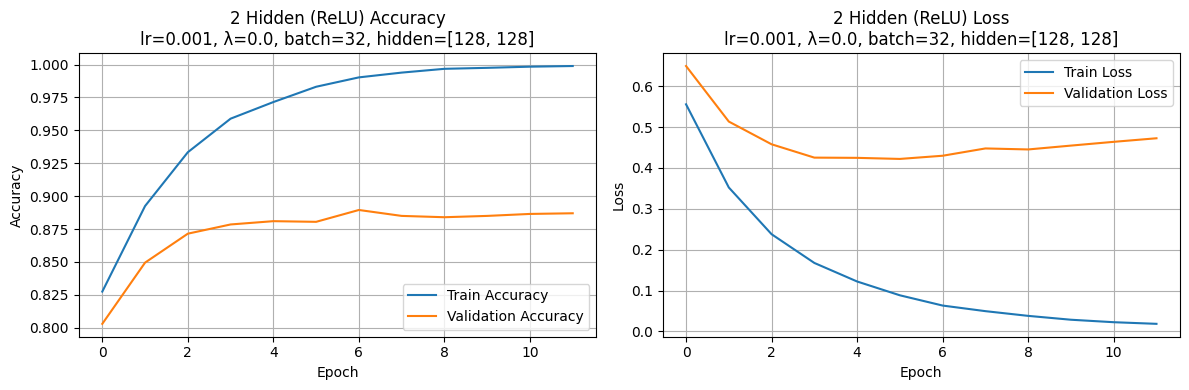

2 Hidden (ReLU) | Config: [256, 256], Val Accuracy: 0.8870


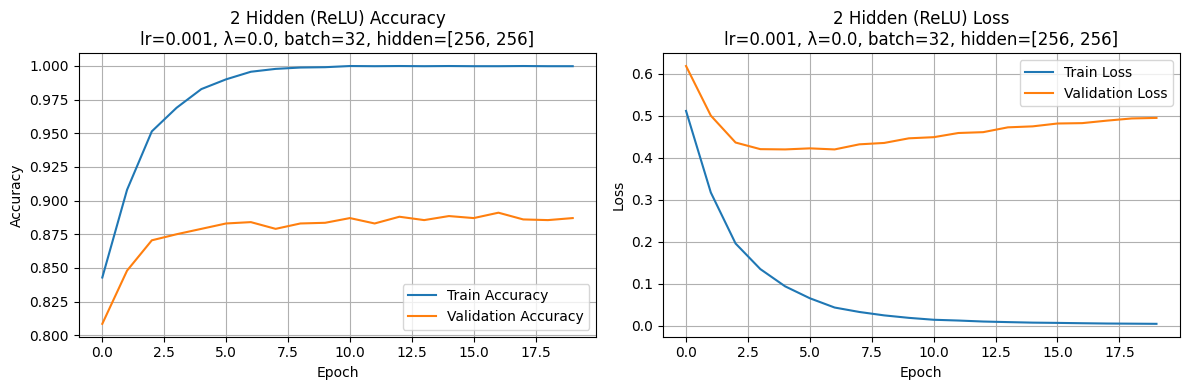

2 Hidden (ReLU) | Config: [32, 32], Val Accuracy: 0.8640


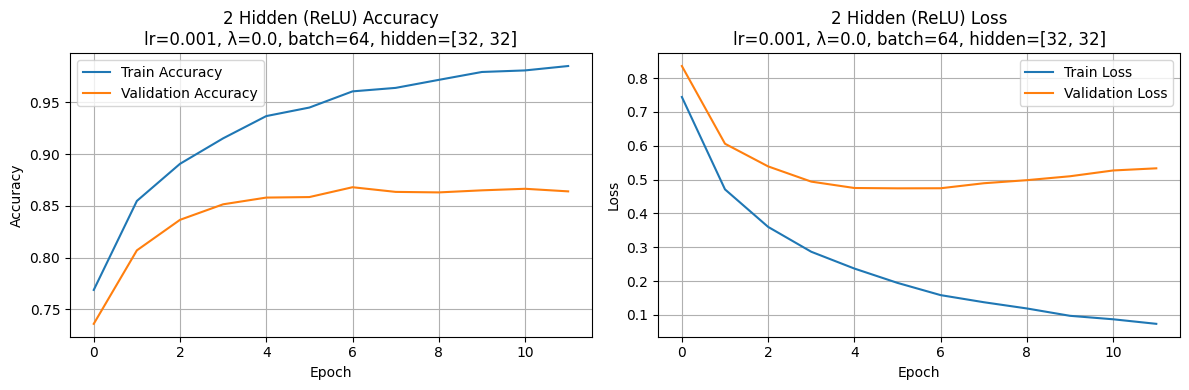

In [ ]:
hidden_sizes = [32, 64, 128, 256]

np.random.seed(1234)

configs = {
    "No Hidden": [[]],
    "1 Hidden (ReLU)": [[h] for h in hidden_sizes],
    "2 Hidden (ReLU)": [[h, h] for h in hidden_sizes],
    "2 Hidden (Sigmoid)": [[h, h] for h in hidden_sizes],
    "2 Hidden (LeakyReLU)": [[h, h] for h in hidden_sizes]
}


activations = {
    "1 Hidden (ReLU)": Relu,
    "2 Hidden (ReLU)": Relu,
    "2 Hidden (Sigmoid)": Sigmoid,
    "2 Hidden (LeakyReLU)": LeakyRelu
}


X_train, y_train, X_test, y_test = load_kmnist()

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=1234
)


learning_rates = [1e-3, 1e-4]
lambdas = [0.0, 0.01]
batch_sizes = [32, 64, 128, 256]


all_best_results = {}


for name, hidden_units_list in configs.items():
    print(f"\n=== Running experiments for: {name} ===")

    if name == "No Hidden":
        hidden_activation = Softmax
    else:
        hidden_activation = activations[name]

    results = run_grid_search(
        X_train_final, y_train_final,
        X_val, y_val,
        hidden_units_list,
        hidden_activation,
        learning_rates,
        lambdas,
        batch_sizes,
        title=name
    )

    best_result = results[0]
    all_best_results[name] = best_result

    print(f"\nBest Result for {name}:")
    print(f" - Hidden Units: {best_result['hidden_units']}")
    print(f" - Learning Rate: {best_result['learning_rate']}")
    print(f" - Lambda: {best_result['lambd']}")
    print(f" - Batch Size: {best_result['batch_size']}")
    print(f" - Validation Accuracy: {best_result['val_accuracy']:.4f}")

# final
print("\n=== Final Summary of Best Results ===")
for name, res in sorted(all_best_results.items()):
    print(f"{name:25} val_acc={res['val_accuracy']:.4f}, hidden={res['hidden_units']}, "
          f"lr={res['learning_rate']}, λ={res['lambd']}, batch={res['batch_size']}")


##Retraining on train+val set and then evaluating test accuracy


=== Retraining Best Models on Full Training Set and Plotting Loss Curves ===
Loaded 5 best models

Retraining for: No Hidden
Test Accuracy for No Hidden: 0.6708


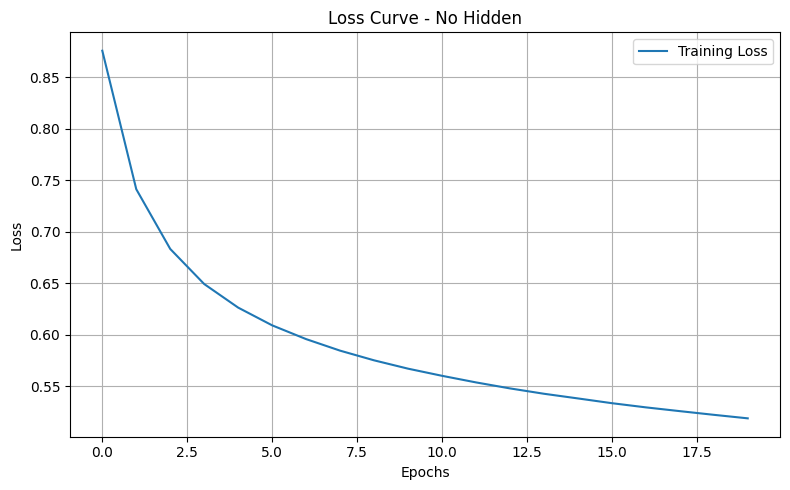

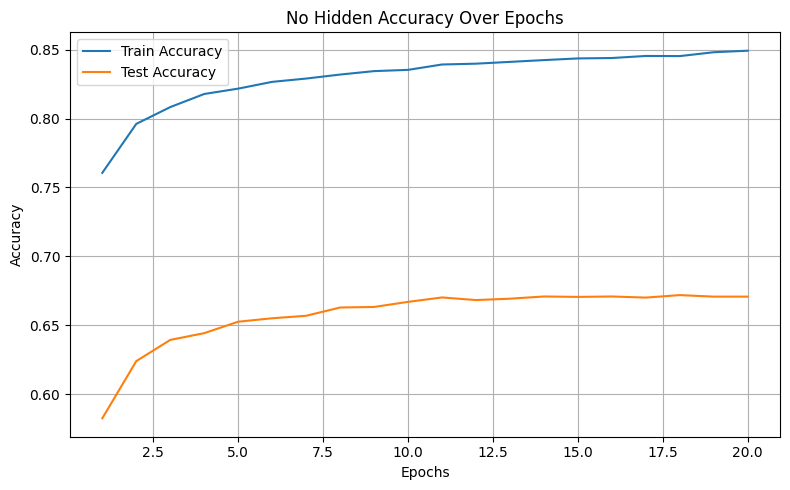


Retraining for: 1 Hidden (ReLU)
Test Accuracy for 1 Hidden (ReLU): 0.8019


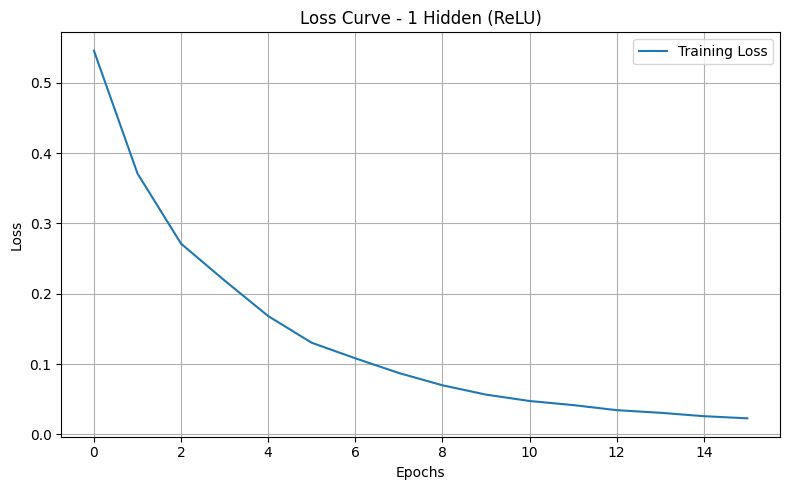

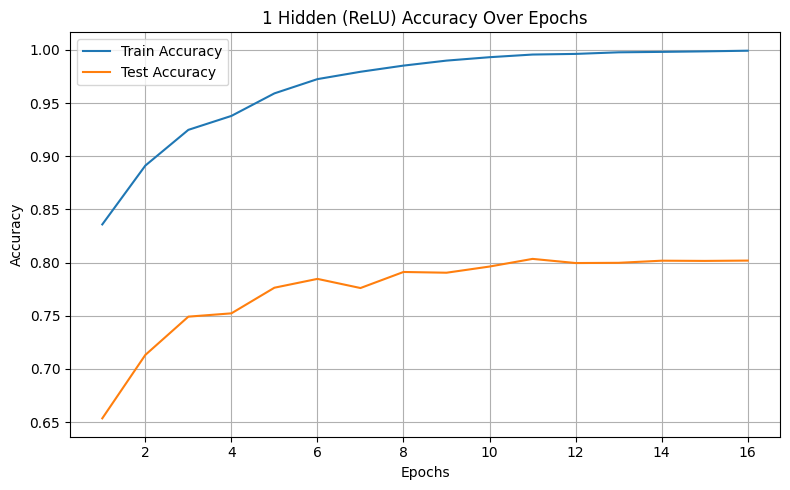


Retraining for: 2 Hidden (ReLU)
Test Accuracy for 2 Hidden (ReLU): 0.8046


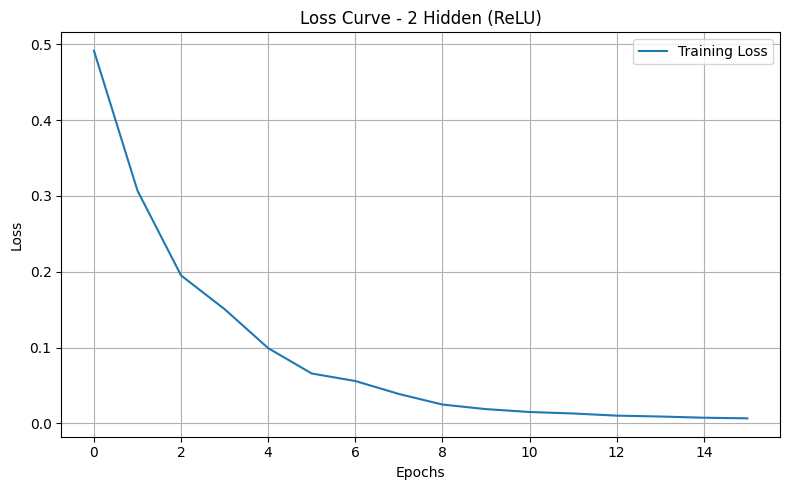

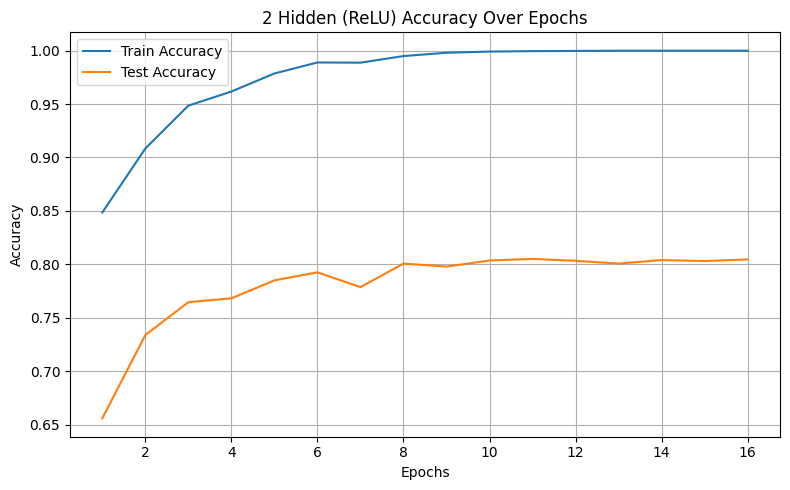


Retraining for: 2 Hidden (Sigmoid)
Test Accuracy for 2 Hidden (Sigmoid): 0.7005


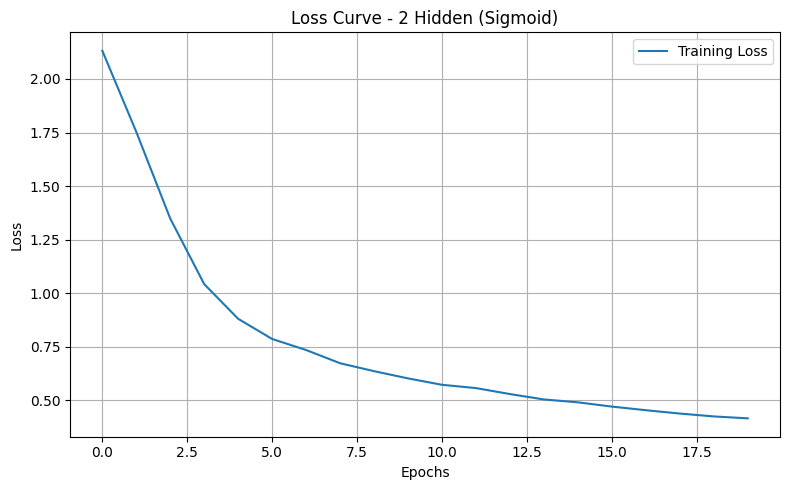

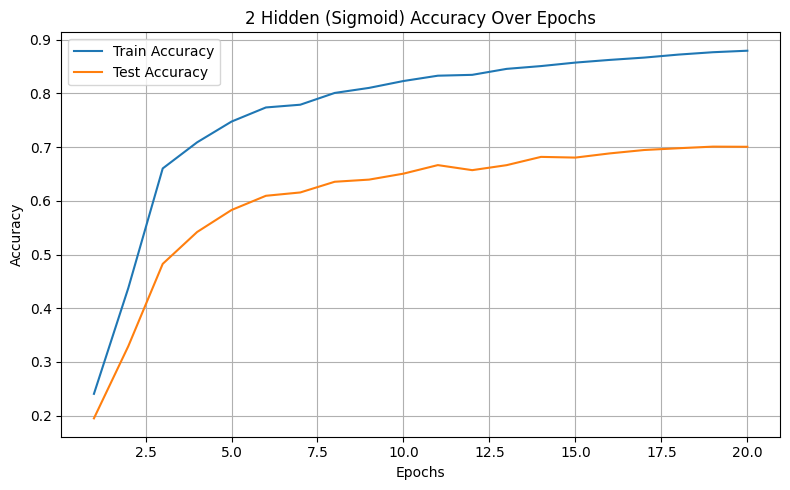


Retraining for: 2 Hidden (LeakyReLU)
Test Accuracy for 2 Hidden (LeakyReLU): 0.8009


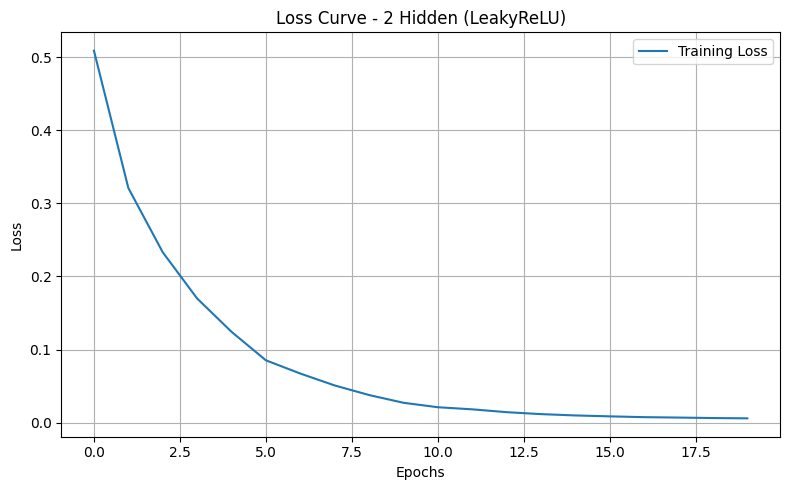

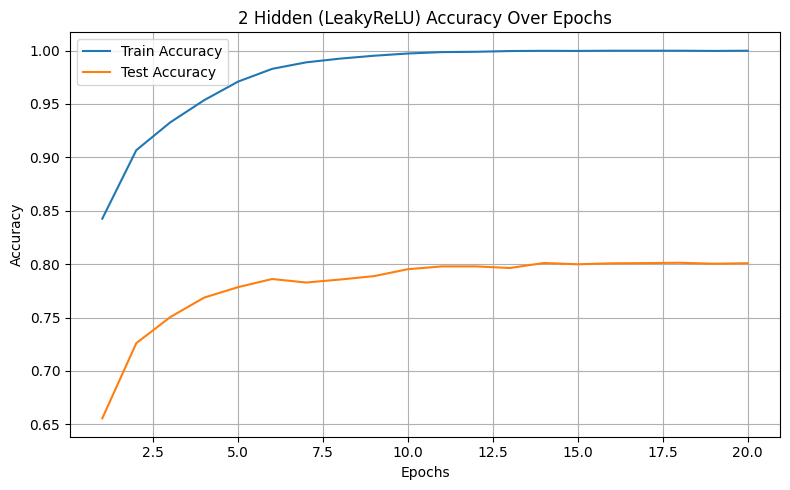

In [ ]:
print("\n=== Retraining Best Models on Full Training Set and Plotting Loss Curves ===")
test_accuracies = {}

activations = {
    "1 Hidden (ReLU)": Relu,
    "2 Hidden (ReLU)": Relu,
    "2 Hidden (Sigmoid)": Sigmoid,
    "2 Hidden (LeakyReLU)": LeakyRelu
}
print(f"Loaded {len(all_best_results)} best models")
for name, best_result in all_best_results.items():
    print(f"\nRetraining for: {name}")

    input_size = X_train.shape[1]
    output_size = len(np.unique(y_train))
    hidden_units = best_result["hidden_units"]


    if name == "No Hidden":
        acts = [Softmax]
    else:
        hidden_activation = activations[name]
        acts = [hidden_activation] * len(hidden_units) + [Softmax]


    dims = [input_size] + hidden_units + [output_size]
    mlp = MLP(dims, acts)


    train_acc_hist, test_acc_hist, train_loss_hist, val_loss_hist = mlp.fit(
        X_train,
        y_train,
        X_test,
        y_test,
        epochs=20,
        batch_size=best_result["batch_size"],
        loss_fn=CrossEntropy,
        lambd=best_result["lambd"],
        learning_rate=best_result["learning_rate"]
    )

    # eval acc
    y_test_pred = mlp.predict(X_test)
    test_acc = np.mean(y_test_pred == y_test)
    test_accuracies[name] = test_acc

    print(f"Test Accuracy for {name}: {test_acc:.4f}")

    # plot loss
    plot_loss_curve(train_loss_hist, model_name=name)

    # plot accuracy
    plot_accuracy_curves(train_acc_hist, test_acc_hist, model_name=name)




##Gradient Check on Toy Models

In [ ]:
num_classes = len(np.unique(y_train))
X_small = X_train[:2]
y_small = y_train[:2]

# relu
print("\n[Gradient Check] ReLU Model")
mlp_relu = MLP([784, 2, 2, num_classes], [Relu, Relu, Softmax])
mlp_relu.loss = CrossEntropy(Softmax)
mlp_relu.lambd = 0.01
mlp_relu.gradient_check(X_small, y_small, num_classes)

# leaky relu
print("\n[Gradient Check] Leaky ReLU Model")
mlp_leaky = MLP([784, 2, 2, num_classes], [LeakyRelu, LeakyRelu, Softmax])
mlp_leaky.loss = CrossEntropy(Softmax)
mlp_leaky.lambd = 0.01
mlp_leaky.gradient_check(X_small, y_small, num_classes)

# sigmoid
print("\n[Gradient Check] Sigmoid Model")
mlp_sigmoid = MLP([784, 2, 2, num_classes], [Sigmoid, Sigmoid, Softmax])
mlp_sigmoid.loss = CrossEntropy(Softmax)
mlp_sigmoid.lambd = 0.01
mlp_sigmoid.gradient_check(X_small, y_small, num_classes)



[Gradient Check] ReLU Model
[DEBUG] Gradient Check - Relative Difference: 0.00000004
Gradients are correct!

[Gradient Check] Leaky ReLU Model
[DEBUG] Gradient Check - Relative Difference: 0.00000002
Gradients are correct!

[Gradient Check] Sigmoid Model
[DEBUG] Gradient Check - Relative Difference: 0.00000005
Gradients are correct!


np.float64(4.981999661008246e-08)

#ConvNets

##Reloading raw image data for ConvNets

In [14]:


# raw KMNIST data
X_train_raw = np.load("kmnist-train-imgs.npz")["arr_0"]
y_train_raw = np.load("kmnist-train-labels.npz")["arr_0"]

X_test_raw = np.load("kmnist-test-imgs.npz")["arr_0"]
y_test_raw = np.load("kmnist-test-labels.npz")["arr_0"]

# convert training and test sets to PyTorch tensors
X_train_tensor = torch.tensor(X_train_raw / 255.0, dtype=torch.float32).unsqueeze(1)  # shape: (N, 1, 28, 28)
y_train_tensor = torch.tensor(y_train_raw, dtype=torch.long)

full_dataset = TensorDataset(X_train_tensor, y_train_tensor)
full_train_loader = DataLoader(full_dataset, batch_size=64, shuffle=True)

X_test_tensor = torch.tensor(X_test_raw / 255.0, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test_raw, dtype=torch.long)


full_dataset = TensorDataset(X_train_tensor, y_train_tensor)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)


##Hyperparameter Tuning

In [24]:
import random
from itertools import product

def set_seed(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(1234)

# Hyperparameter search space
learning_rates = [1e-3, 1e-5]
num_filters_list = [32, 64]
kernel_sizes = [3, 5]
strides = [1, 2]
paddings = [0, 1]
dropouts = [0.3, 0.5]
hidden_units_list = [32, 64, 128, 256]

# Randomized search
grid = list(product(
    learning_rates,
    num_filters_list,
    kernel_sizes,
    strides,
    paddings,
    dropouts,
    hidden_units_list
))
sampled_grid = random.sample(grid, k=25)

results = []

for lr, nf, ks, st, pad, drop, fc_hidden in sampled_grid:
    print(f"Testing: lr={lr}, filters={nf}, kernel={ks}, stride={st}, pad={pad}, dropout={drop}, hidden_units={fc_hidden}")
    try:
        model = CustomConvNet(
            num_filters=nf,
            kernel_size=ks,
            stride=st,
            padding=pad,
            dropout=drop,
            fc_hidden=fc_hidden
        )

        trainer = CNNTrainer(model, device=device, lr=lr, patience=3)


        history = trainer.train(train_loader, val_loader=val_loader, test_loader=test_loader, epochs=2)
        val_acc = history["val_acc"][-1]
        test_acc = history["test_acc"][-1] if "test_acc" in history else None
        train_acc = history["train_acc"][-1]

        results.append({
            "learning_rate": lr,
            "filters": nf,
            "kernel": ks,
            "stride": st,
            "padding": pad,
            "dropout": drop,
            "hidden_units": fc_hidden,
            "val_accuracy": val_acc,
            "test_accuracy": test_acc,
            "train_accuracy": train_acc,
            "history": history
        })

        print(f"  Validation Accuracy: {val_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    except Exception as e:
        print(f"  Failed config: lr={lr}, filters={nf}, ks={ks}, stride={st}, pad={pad}, dropout={drop}, hidden_units={fc_hidden}")
        print(f"  Error: {e}")

# top 5 configs
top_results = sorted(results, key=lambda x: x["val_accuracy"], reverse=True)[:5]
print("\nTop 5 Configurations:")
for i, res in enumerate(top_results):
    print(f"{i+1}. Val Acc: {res['val_accuracy']:.4f}, Test Acc: {res['test_accuracy']:.4f}, Train Acc: {res['train_accuracy']:.4f}, Config: {res}")


Testing: lr=1e-05, filters=64, kernel=5, stride=1, pad=0, dropout=0.3, hidden_units=64
  Failed config: lr=1e-05, filters=64, ks=5, stride=1, pad=0, dropout=0.3, hidden_units=64
  Error: Calculated padded input size per channel: (4 x 4). Kernel size: (5 x 5). Kernel size can't be greater than actual input size
Testing: lr=0.001, filters=32, kernel=3, stride=2, pad=1, dropout=0.5, hidden_units=64
  Failed config: lr=0.001, filters=32, ks=3, stride=2, pad=1, dropout=0.5, hidden_units=64
  Error: Given input size: (128x1x1). Calculated output size: (128x0x0). Output size is too small
Testing: lr=0.001, filters=32, kernel=3, stride=1, pad=0, dropout=0.3, hidden_units=64
Epoch 01 | Train Loss: 0.6952, Acc: 0.7700 | Val Loss: 0.3040, Acc: 0.9047 | Test Acc: 0.8092
Epoch 02 | Train Loss: 0.2505, Acc: 0.9229 | Val Loss: 0.2155, Acc: 0.9333 | Test Acc: 0.8580
  Validation Accuracy: 0.9333, Test Accuracy: 0.8580
Testing: lr=0.001, filters=32, kernel=3, stride=2, pad=0, dropout=0.5, hidden_units=

##Best Model after Hyperparameter Tuning


Best Configuration:
learning_rate                                                 0.001
filters                                                          32
kernel                                                            3
stride                                                            1
padding                                                           1
dropout                                                         0.3
hidden_units                                                     32
val_accuracy                                               0.974917
test_accuracy                                                0.9278
train_accuracy                                             0.961562
history           {'train_loss': [0.4307224534799655, 0.12749323...
Name: 3, dtype: object
Epoch 01 | Train Loss: 0.3594, Acc: 0.8862 | Test Acc: 0.9003
Epoch 02 | Train Loss: 0.1123, Acc: 0.9669 | Test Acc: 0.9324
Epoch 03 | Train Loss: 0.0735, Acc: 0.9780 | Test Acc: 0.9437
Epoch 04 | Train Loss:

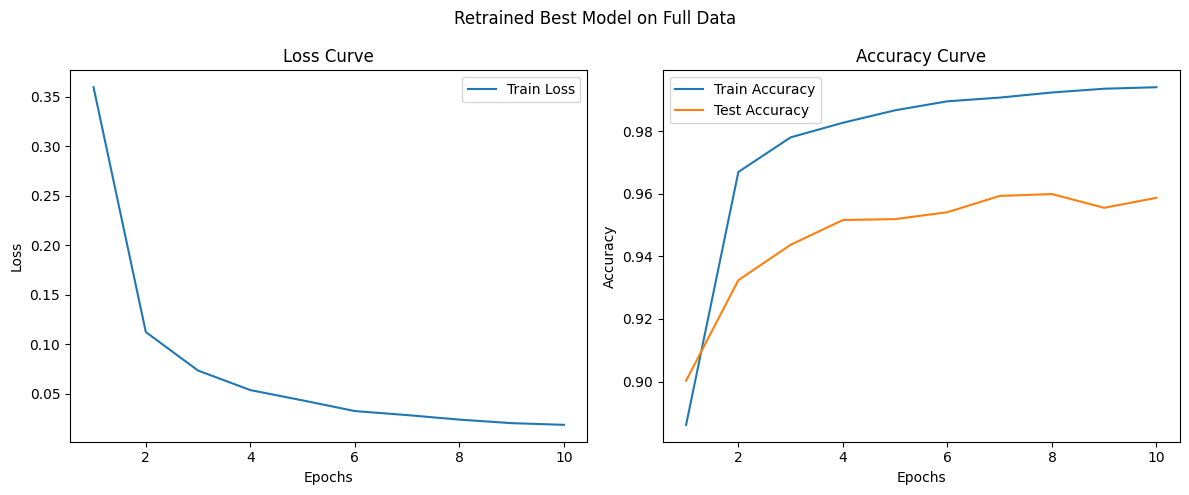

In [28]:
set_seed(1234)

df = pd.DataFrame(results)
df = df.sort_values(by="val_accuracy", ascending=False)
best_config = df.iloc[0]

print("\nBest Configuration:")
print(best_config)


best_model = CustomConvNet(
    num_filters=int(best_config["filters"]),
    kernel_size=int(best_config["kernel"]),
    stride=int(best_config["stride"]),
    padding=int(best_config["padding"]),
    dropout=float(best_config["dropout"]),
    fc_hidden=int(best_config["hidden_units"])
)


best_trainer = CNNTrainer(best_model, device=device, lr=float(best_config["learning_rate"]), patience=5)
final_history = best_trainer.train(full_train_loader, val_loader=None, test_loader=test_loader, epochs=10)

# plot
def plot_history(history, title="Training History"):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12, 5))

    # loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    if "val_loss" in history and history["val_loss"]:
        plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    if "val_acc" in history and history["val_acc"]:
        plt.plot(epochs, history["val_acc"], label="Val Accuracy")
    if "test_acc" in history and history["test_acc"]:
        plt.plot(epochs, history["test_acc"], label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

#results
plot_history(final_history, title="Retrained Best Model on Full Data")

In [29]:
test_acc = best_trainer.test_accuracy(test_loader)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9587

Final Test Accuracy: 0.9587
